In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn-dark-palette')
%config InlineBackend.figure_format = 'retina'


In [2]:
import re
from bs4 import BeautifulSoup

import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('train_Quora.csv')
print("Number of data points: ", df.shape[0])

Number of data points:  404290


In [4]:


df.head()

id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2   2     5     6  How can I increase the speed of my internet co...   
3   3     7     8  Why am I mentally very lonely? How can I solve...   
4   4     9    10  Which one dissolve in water quikly sugar, salt...   

                                           question2  is_duplicate  
0  What is the step by step guide to invest in sh...             0  
1  What would happen if the Indian government sto...             0  
2  How can Internet speed be increased by hacking...             0  
3  Find the remainder when [math]23^{24}[/math] i...             0  
4            Which fish would survive in salt water?             0

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [6]:
df.describe()

id           qid1           qid2   is_duplicate
count  404290.000000  404290.000000  404290.000000  404290.000000
mean   202144.500000  217243.942418  220955.655337       0.369198
std    116708.614502  157751.700002  159903.182629       0.482588
min         0.000000       1.000000       2.000000       0.000000
25%    101072.250000   74437.500000   74727.000000       0.000000
50%    202144.500000  192182.000000  197052.000000       0.000000
75%    303216.750000  346573.500000  354692.500000       1.000000
max    404289.000000  537932.000000  537933.000000       1.000000

In [7]:
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [8]:
df.duplicated().sum()

0

We are given a minimal number of data fields here, consisting of:

- id: Looks like a simple rowID

- qid{1, 2}: The unique ID of each question in the pair

- question{1, 2}: The actual textual contents of the questions.

- is_duplicate: The label that we are trying to predict - whether the two questions are duplicates of each other.

By looking at the info of the dataset -

We are able to see that there are 2 null/NaN values in Question2 and 1 null/NaN value in Question1. We have to handle this in feature engineering.

#### Distribution of duplicated and non duplicated questions

In [9]:
df.is_duplicate.value_counts()

0    255027
1    149263
Name: is_duplicate, dtype: int64

#### Distribution of data points among output classes

In [10]:
df['is_duplicate'].value_counts(normalize=True) * 100

0    63.080215
1    36.919785
Name: is_duplicate, dtype: float64

<AxesSubplot:xlabel='is_duplicate'>

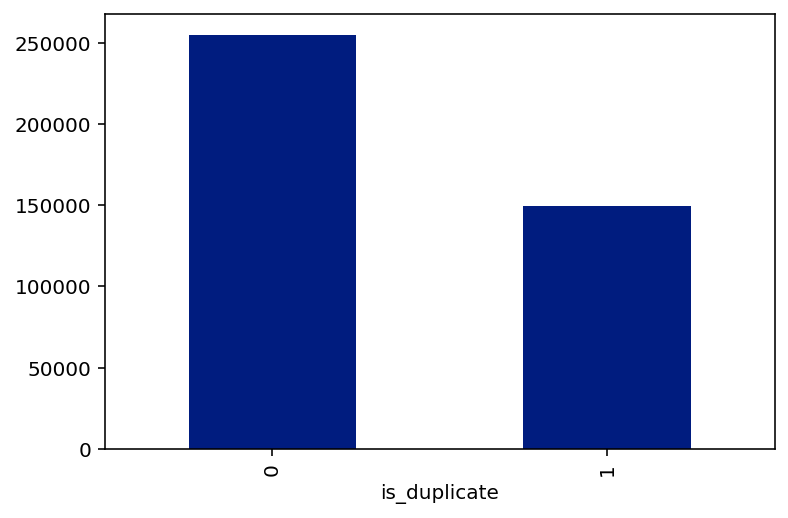

In [11]:
df.groupby('is_duplicate')['id'].count().plot.bar()

In [12]:
print("Total number of Question pairs for Training: ", len(df))

Total number of Question pairs for Training:  404290


#### Number of unique questions

In [13]:
qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
unique_qids = len(np.unique(qids))
qs_morethan_onetime = np.sum(qids.value_counts() > 1)

print("Total number of Unique Questions: ", unique_qids)

print ('Number of unique questions that appear more than one time: {} ({}%)\n'.format(qs_morethan_onetime,qs_morethan_onetime/unique_qids*100))

print ('Max number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

Total number of Unique Questions:  537933
Number of unique questions that appear more than one time: 111780 (20.77953945937505%)

Max number of times a single question is repeated: 157



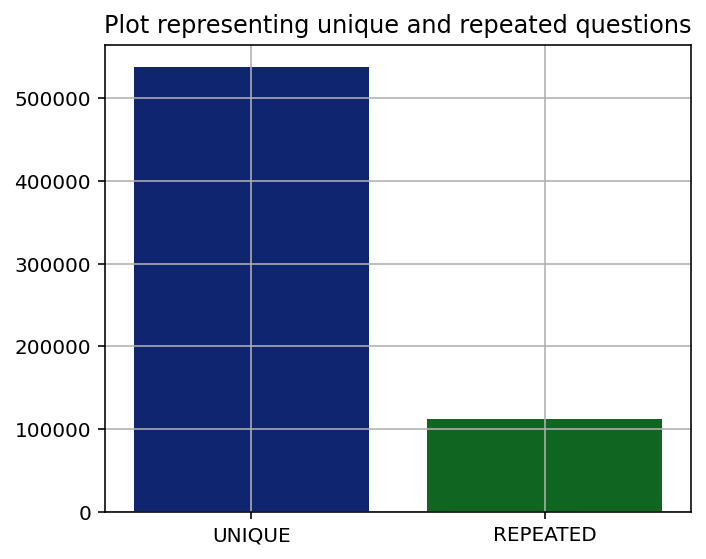

In [14]:
q_values = qids.value_counts().values
x = ["UNIQUE", "REPEATED"]
y = [unique_qids, qs_morethan_onetime]


plt.figure(figsize=(5, 4))
plt.title("Plot representing unique and repeated questions")
sns.barplot(x, y)
plt.tight_layout()
plt.grid()
plt.show()

#### Number of occurrences of each question

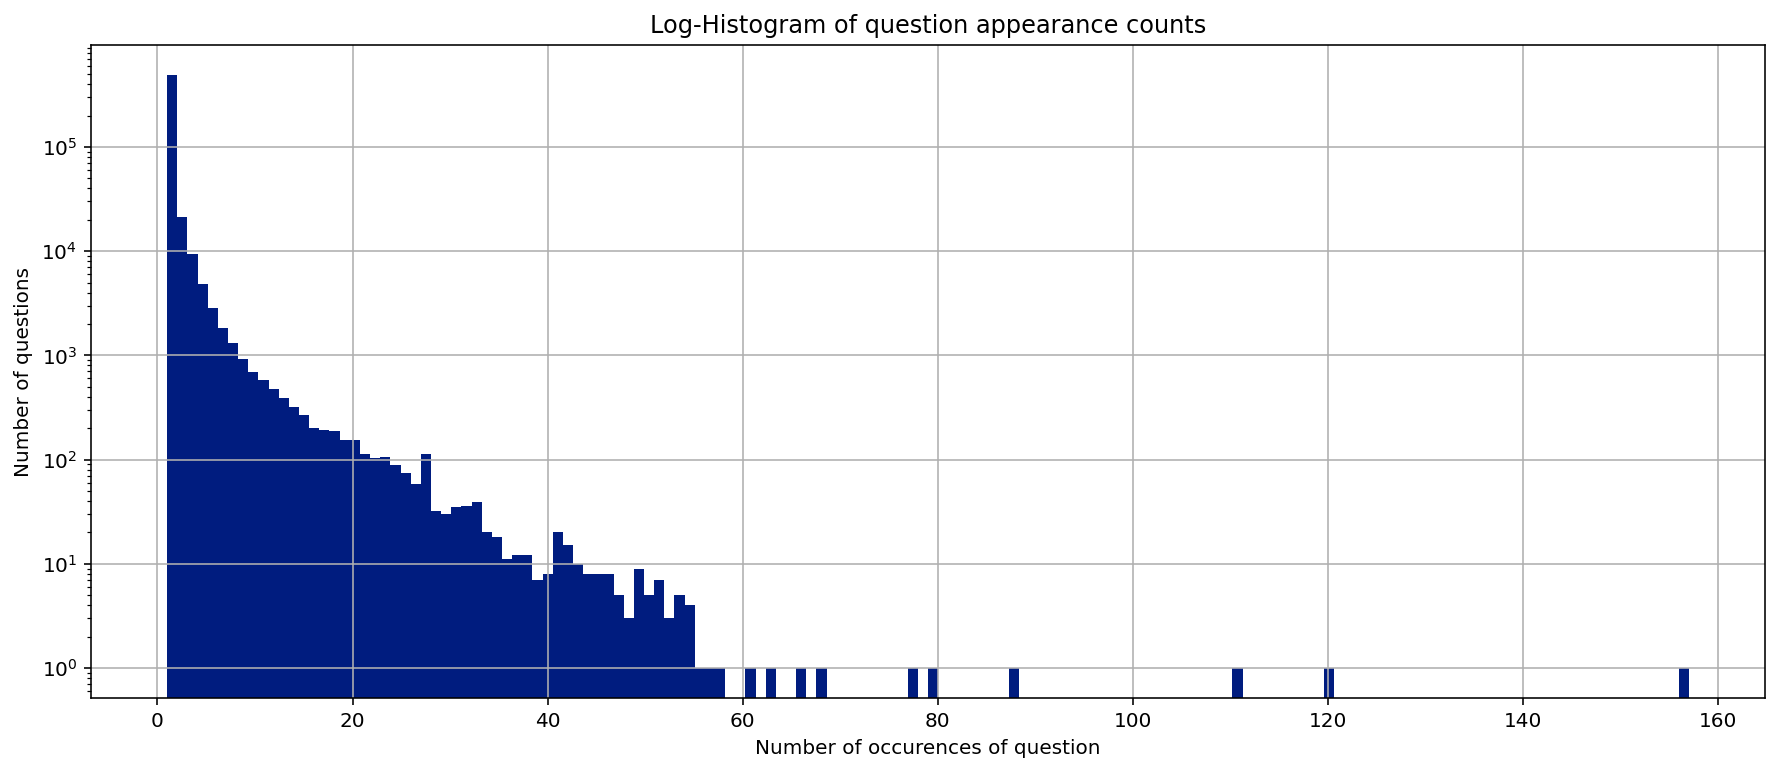

In [15]:
plt.figure(figsize=(15, 6))

plt.hist(qids.value_counts(), bins=150)

plt.yscale('log')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurences of question')
plt.ylabel('Number of questions')

plt.grid()
plt.show()

In [16]:
print("Question which occurred most number of time ->> ", df[df['qid1'] == qids.value_counts().index[0]]['question1'].iloc[0])

Question which occurred most number of time ->>  What are the best ways to lose weight?


#### Checking for NULL values

In [17]:
#Checking whether there are any rows with null values
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

            id    qid1    qid2                         question1  \
105780  105780  174363  174364    How can I develop android app?   
201841  201841  303951  174364  How can I create an Android app?   
363362  363362  493340  493341                               NaN   

                                                question2  is_duplicate  
105780                                                NaN             0  
201841                                                NaN             0  
363362  My Chinese name is Haichao Yu. What English na...             0  




<b>There is 1 null value in question 1 column.
There are 2 null values in question 2 column.</b>

In [18]:
# Filling the null values with ' '
df = df.fillna('')
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


## Basic Feature Extraction

- freq_qid1 = Frequency of qid1's
- freq_qid2 = Frequency of qid2's
- q1len = Length of q1
- q2len = Length of q2
- q1_n_words = Number of words in Question 1
- q2_n_words = Number of words in Question 2
-  word_Common = (Number of common unique words in Question 1 and Question 2)
- word_Total =(Total num of words in Question 1 + Total num of words in Question 2)
- word_share = (word_common)/(word_Total)
- freq_q1+freq_q2 = sum total of frequency of qid1 and qid2
- freq_q1-freq_q2 = absolute difference of frequency of qid1 and qid2
- No_Questions_q1 = Total number of questions in qid1
- No_Questions_q2 = Total number of questions in qid2
- q1_q2_difference = Number of words which are in Question 1 but not in Question 2
- q2_q1_difference = Number of words which are in Question 2 but not in Question 1
- diff_len = Difference in absolute value of the Length of q1 and q2

In [19]:
df['q1len'] = df['question1'].str.len() 
df['q2len'] = df['question2'].str.len()
df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))

def normalized_word_Common(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * len(w1 & w2)
df['word_Common'] = df.apply(normalized_word_Common, axis=1)

def normalized_word_Total(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * (len(w1) + len(w2))
df['word_Total'] = df.apply(normalized_word_Total, axis=1)

def normalized_word_share(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
df['word_share'] = df.apply(normalized_word_share, axis=1)

def normalized_word_difference_1(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * len(w1.difference(w2))
df['q1_q2_difference'] = df.apply(normalized_word_difference_1, axis=1)

def normalized_word_difference_2(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * len(w2.difference(w1))
df['q2_q1_difference'] = df.apply(normalized_word_difference_2, axis=1)


df['No_Questions_q1'] = df['question1'].apply(lambda row: str(row).count('?'))
df['No_Questions_q2'] = df['question2'].apply(lambda row: str(row).count('?'))

df['diff_len'] = abs(df.q1len - df.q2len)

In [20]:
df.head(10)

id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2   2     5     6  How can I increase the speed of my internet co...   
3   3     7     8  Why am I mentally very lonely? How can I solve...   
4   4     9    10  Which one dissolve in water quikly sugar, salt...   
5   5    11    12  Astrology: I am a Capricorn Sun Cap moon and c...   
6   6    13    14                                Should I buy tiago?   
7   7    15    16                     How can I be a good geologist?   
8   8    17    18                    When do you use シ instead of し?   
9   9    19    20  Motorola (company): Can I hack my Charter Moto...   

                                           question2  is_duplicate  q1len  \
0  What is the step by step guide to invest in sh...             0     66   
1  What would happen if the Indian government sto...             0     51   
2  How can Internet speed be increased by hacking...             0     73   
3  Find the remainder when [math]23^{24}[/math] i...             0     50   
4            Which fish would survive in salt water?             0     76   
5  I'm a triple Capricorn (Sun, Moon and ascendan...             1     86   
6  What keeps childern active and far from phone ...             0     19   
7          What should I do to be a great geologist?             1     30   
8              When do you use "&" instead of "and"?             0     31   
9  How do I hack Motorola DCX3400 for free internet?             0     60   

   q2len  q1_n_words  q2_n_words  word_Common  word_Total  word_share  \
0     57          14          12         10.0        23.0    0.434783   
1     88           8          13          4.0        20.0    0.200000   
2     59          14          10          4.0        24.0    0.166667   
3     65          11           9          0.0        19.0    0.000000   
4     39          13           7          2.0        20.0    0.100000   
5     90          16          16          8.0        31.0    0.258065   
6     62           4          11          0.0        14.0    0.000000   
7     41           7           9          4.0        16.0    0.250000   
8     37           8           8          6.0        16.0    0.375000   
9     49           9           9          3.0        18.0    0.166667   

   q1_q2_difference  q2_q1_difference  No_Questions_q1  No_Questions_q2  \
0               2.0               1.0                1                1   
1               4.0               8.0                1                1   
2              10.0               6.0                1                1   
3              10.0               9.0                2                1   
4              11.0               5.0                1                1   
5               7.0               8.0                1                1   
6               4.0              10.0                1                1   
7               3.0               5.0                1                1   
8               2.0               2.0                1                1   
9               6.0               6.0                1                1   

   diff_len  
0         9  
1        37  
2        14  
3        15  
4        37  
5         4  
6        43  
7        11  
8         6  
9        11

## Analysis of some of the extracted features

<b>Feature : q1_n_words & q2_n_words

In [21]:
print ("Minimum length of the questions in question1 : " , min(df['q1_n_words']))

print ("Minimum length of the questions in question2 : " , min(df['q2_n_words']))



Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  1


In [22]:
print ("Number of Questions with minimum length [question1] :", df[df['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", df[df['q2_n_words']== 1].shape[0])

Number of Questions with minimum length [question1] : 67
Number of Questions with minimum length [question2] : 24


<b>Feature : word_common

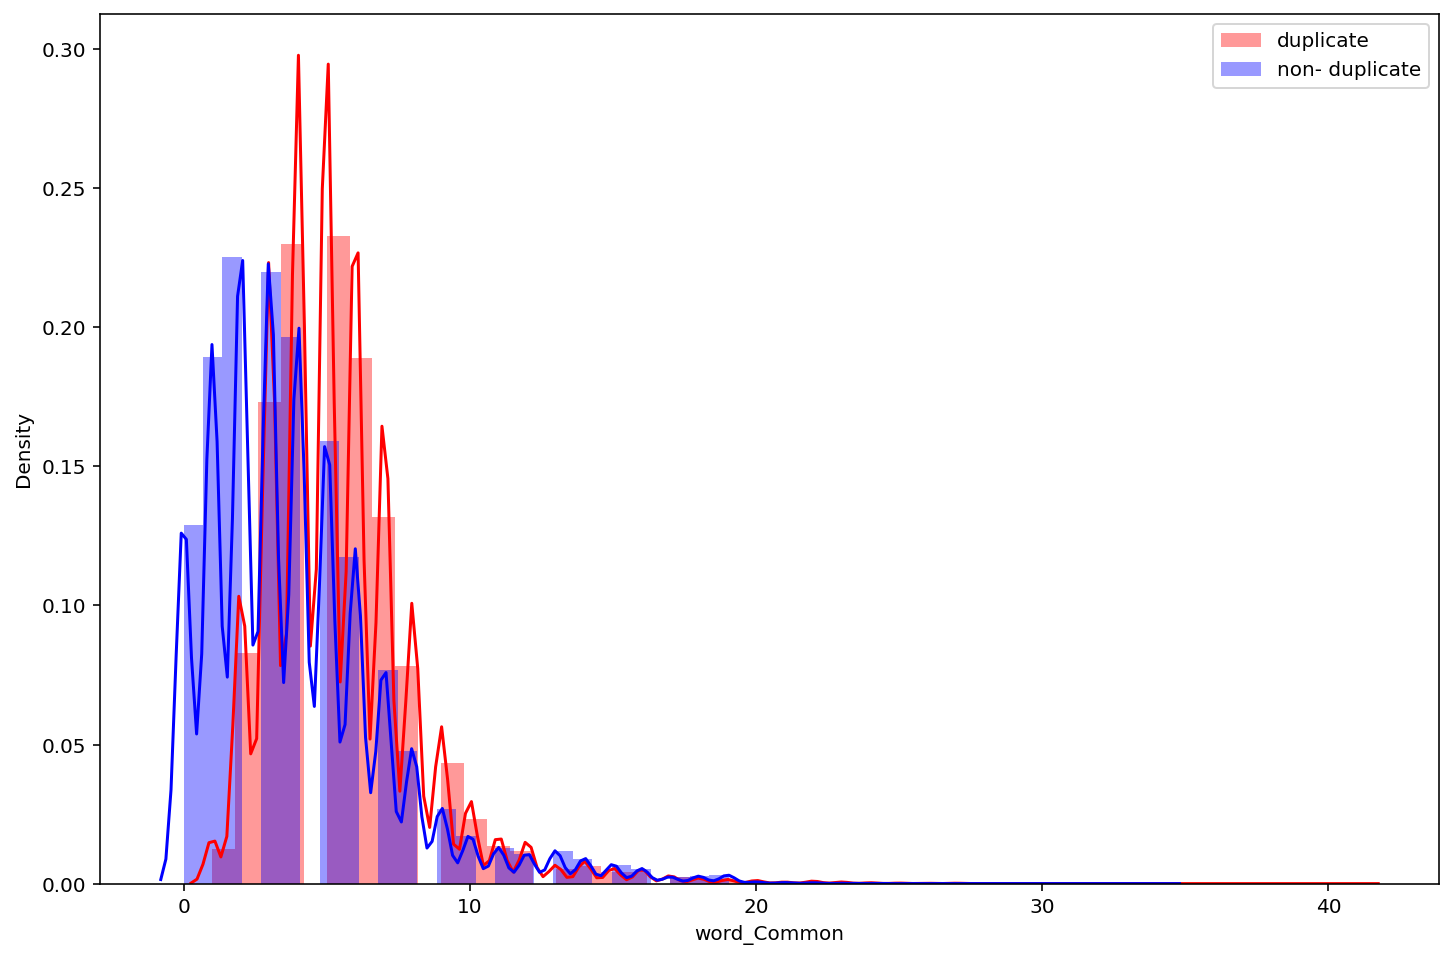

In [23]:

plt.figure(figsize=(12, 8))
sns.distplot(df[df['is_duplicate'] == 1.0]['word_Common'][0:] , label = "duplicate", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_Common'][0:] , label = "non- duplicate" , color = 'blue')
plt.legend()
plt.show()

<b>Feature : word_Total

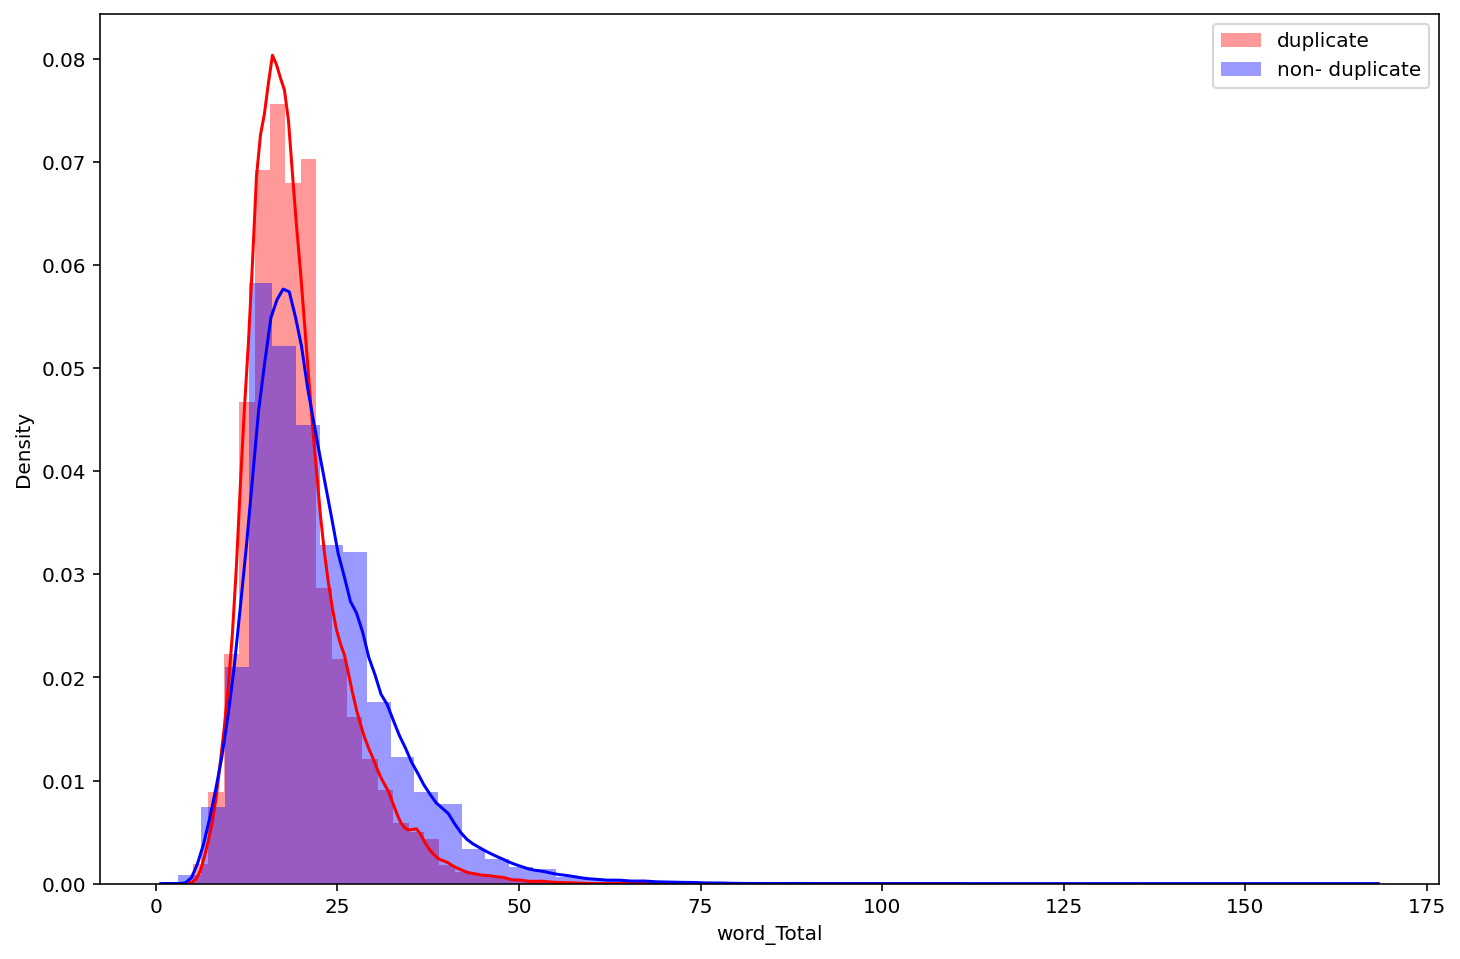

In [24]:
plt.figure(figsize=(12, 8))
sns.distplot(df[df['is_duplicate'] == 1.0]['word_Total'][0:] , label = "duplicate", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_Total'][0:] , label = "non- duplicate" , color = 'blue')
plt.legend()
plt.show()

<b>Feature : word_share

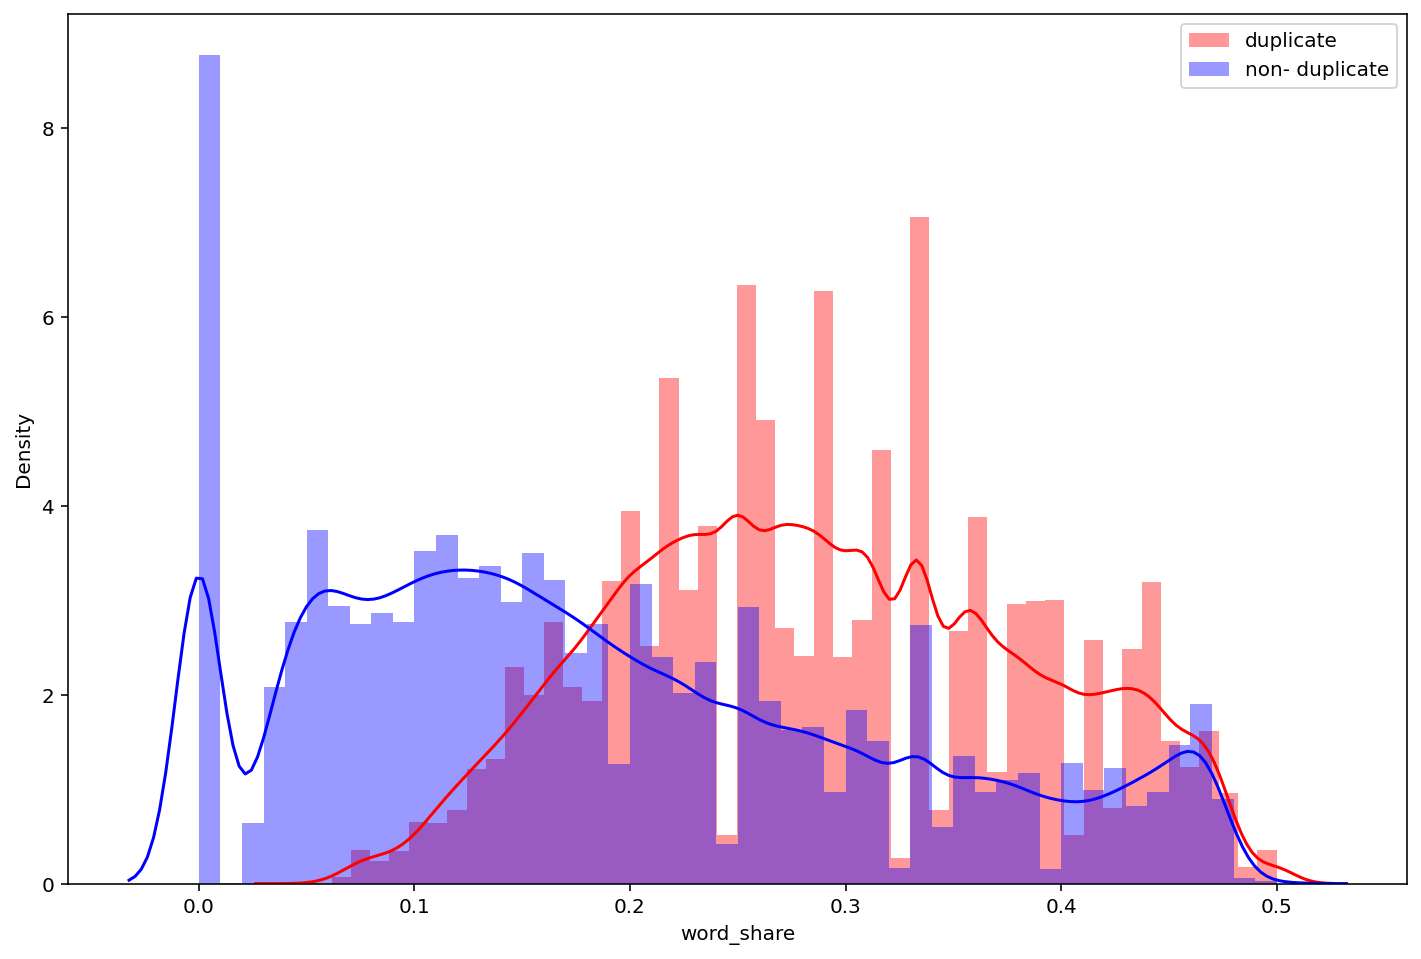

In [25]:
plt.figure(figsize=(12, 8))
sns.distplot(df[df['is_duplicate'] == 1.0]['word_share'][0:] , label = "duplicate", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_share'][0:] , label = "non- duplicate" , color = 'blue')
plt.legend()
plt.show()

- The distributions for normalized word_share have some overlap on the far right-hand side, i.e., there are quite a lot of questions with high word similarity
- The average word share and Common no. of words of qid1 and qid2 is more when they are duplicate(Similar)

<b>Feature : q1_q2_difference & q2_q1_difference

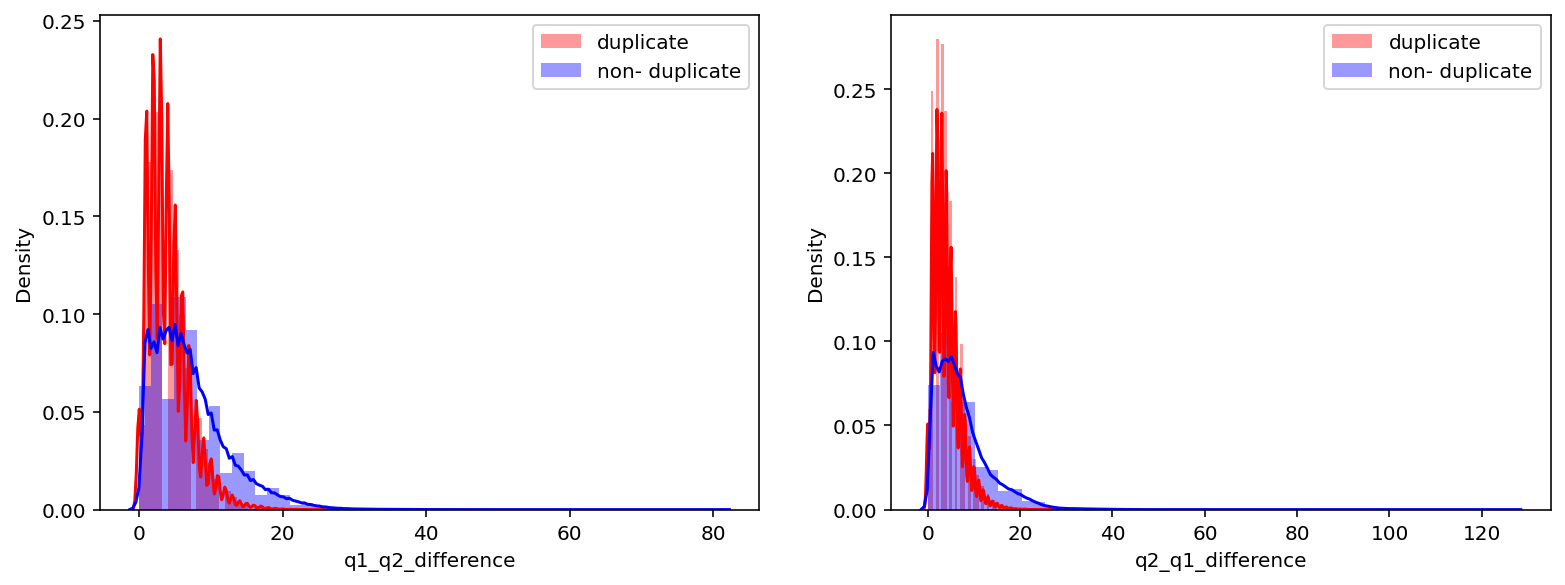

In [26]:
plt.figure(figsize=(13, 10))


plt.subplot(2,2,1)
sns.distplot(df[df['is_duplicate'] == 1.0]['q1_q2_difference'][0:] , label = "duplicate", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['q1_q2_difference'][0:] , label = "non- duplicate" , color = 'blue' )
plt.legend()

plt.subplot(2,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['q2_q1_difference'][0:] , label = "duplicate", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['q2_q1_difference'][0:] , label = "non- duplicate" , color = 'blue' )
plt.legend()
plt.show()

<b> Feature : No_Questions_q1 & No_Questions_q2

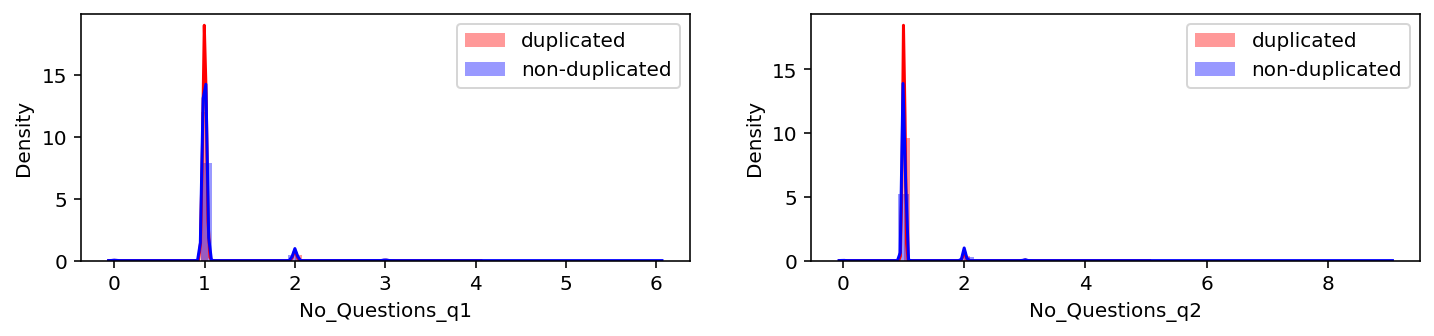

In [27]:
plt.figure(figsize=(12, 5))


plt.subplot(2,2,1)
sns.distplot(df[df['is_duplicate'] == 1.0]['No_Questions_q1'][0:] , label = "duplicated", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['No_Questions_q1'][0:] , label = "non-duplicated" , color = 'blue' )
plt.legend()


plt.subplot(2,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['No_Questions_q2'][0:] , label = "duplicated", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['No_Questions_q2'][0:] , label = "non-duplicated" , color = 'blue' )
plt.legend()
plt.show()


<b> Feature : diff_len

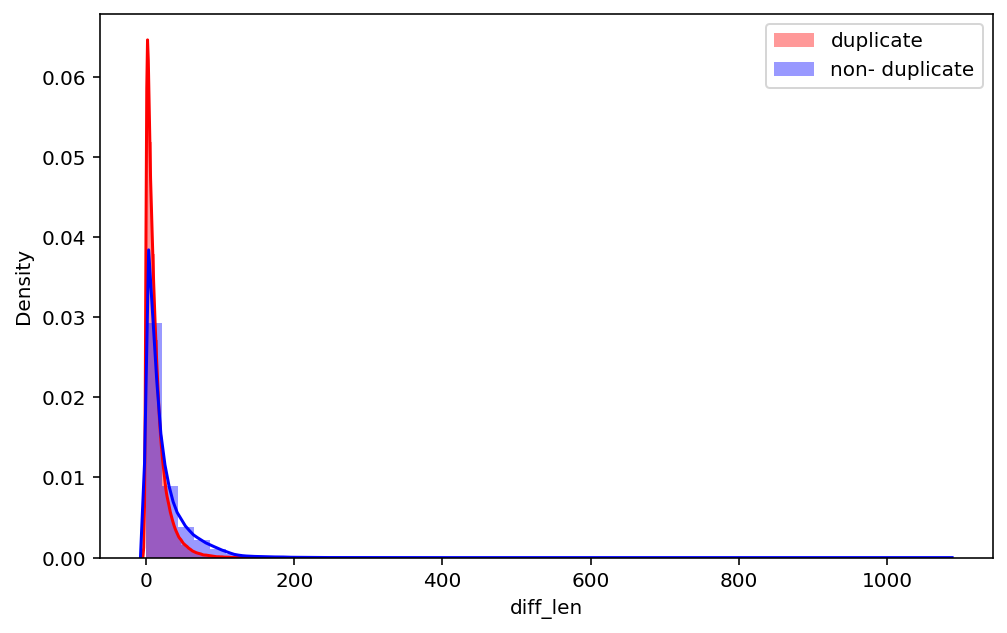

In [28]:
plt.figure(figsize=(8, 5))
sns.distplot(df[df['is_duplicate'] == 1.0]['diff_len'][0:] , label = "duplicate", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['diff_len'][0:] , label = "non- duplicate" , color = 'blue')
plt.legend()
plt.show()

# Preprocessing of Text

- Removing html tags
- Removing Punctuations 
- Performing lemmatization
- Removing Stopwords
- Expanding contractions etc.

In [29]:
def preprocess(q):
    
    q = str(q).lower().strip()
    
     # Replace certain special characters with their string equivalents
    q = q.replace('%', ' percent')
    q = q.replace('$', ' dollar ')
    q = q.replace('₹', ' rupee ')
    q = q.replace('€', ' euro ')
    q = q.replace('@', ' at ')
    
     # The pattern '[math]' appears around 900 times in the whole dataset.
    q = q.replace('[math]', '')
    
    # Replacing some numbers with string equivalents 
    q = q.replace(',000,000,000 ', 'b ')
    q = q.replace(',000,000 ', 'm ')
    q = q.replace(',000 ', 'k ')
    
    q = re.sub(r'([0-9]+)000000000', r'\1b', q)
    q = re.sub(r'([0-9]+)000000', r'\1m', q)
    q = re.sub(r'([0-9]+)000', r'\1k', q)
    
    # Decontracting words
    # https://en.wikipedia.org/wiki/Wikipedia%3aList_of_English_contractions
    # https://stackoverflow.com/a/19794953
    contractions = { 
    "ain't": "am not",
    "aren't": "are not",
    "can't": "can not",
    "can't've": "can not have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
    }

    q_decontracted = []

    for word in q.split():
        if word in contractions:
            word = contractions[word]

        q_decontracted.append(word)

    q = ' '.join(q_decontracted)
    q = q.replace("'ve", " have")
    q = q.replace("n't", " not")
    q = q.replace("doesnt", "does not")
    q = q.replace("'re", " are")
    q = q.replace("'ll", " will")
    
    # Removing HTML tags
    q = BeautifulSoup(q)
    q = q.get_text()
    
    
    
    # Remove punctuations
    pattern = re.compile('\W')
    q = re.sub(pattern, ' ', q).strip()
    
    
    

    
    return q


In [30]:
df['question1'] = df['question1'].apply(preprocess)
df['question2'] =df['question2'].apply(preprocess)

In [31]:
sample_df=df.sample(100000, random_state=42)
sample_df.head()

id    qid1    qid2  \
8067      8067   15738   15739   
368101  368101   12736  104117   
70497    70497  121486  121487   
226567  226567  254474  258192   
73186    73186   48103    3062   

                                                question1  \
8067                    how do i play pokémon go in korea   
368101  what are some of the best side dishes for crab...   
70497   which is more advisable and better material fo...   
226567        how do i improve logical programming skills   
73186               how close we are to see 3rd world war   

                                                question2  is_duplicate  \
8067                    how do i play pokémon go in china             0   
368101  what are some good side dishes for buffalo chi...             0   
70497        what is the best server setup for buddypress             0   
226567  how can i improve my logical skills for progra...             1   
73186                        how close is a world war iii             1   

        q1len  q2len  q1_n_words  q2_n_words  word_Common  word_Total  \
8067       34     34           8           8          7.0        16.0   
368101     53     51          11           9          6.0        20.0   
70497      96     45          16           8          2.0        24.0   
226567     44     52           7           9          4.0        16.0   
73186      38     29           9           7          3.0        16.0   

        word_share  q1_q2_difference  q2_q1_difference  No_Questions_q1  \
8067      0.437500               1.0               1.0                1   
368101    0.300000               5.0               3.0                1   
70497     0.083333              14.0               6.0                1   
226567    0.250000               3.0               5.0                1   
73186     0.187500               6.0               4.0                1   

        No_Questions_q2  diff_len  
8067                  1         0  
368101                1         2  
70497                 1        51  
226567                1         8  
73186                 1         9

#### Lemmatization

In [32]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mansi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\mansi\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [33]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

In [34]:
lemmatizer = WordNetLemmatizer()

In [35]:
def lemma(q):
    x=""
    sentence_words = nltk.word_tokenize(q)
    for word in sentence_words:
        x=x + " " +(lemmatizer.lemmatize(word, pos='n'))
       
        
    return x

In [36]:
sample_df['question1'] = df['question1'].apply(lemma)
sample_df['question2'] = df['question2'].apply(lemma)

In [37]:
sample_df.head(10)

id    qid1    qid2  \
8067      8067   15738   15739   
368101  368101   12736  104117   
70497    70497  121486  121487   
226567  226567  254474  258192   
73186    73186   48103    3062   
215105  215105  177688   83888   
253209  253209  367707  153452   
354651  354651  483796   11244   
104478  104478  172497  172498   
163628  163628  254474  254475   

                                                question1  \
8067                    how do i play pokémon go in korea   
368101   what are some of the best side dish for crab ...   
70497    which is more advisable and better material f...   
226567         how do i improve logical programming skill   
73186               how close we are to see 3rd world war   
215105    what do chinese people think about donald trump   
253209       how many hour a week do google employee work   
354651   how can we follow a quora question privately ...   
104478                      why are cat so overprotective   
163628         how do i improve logical programming skill   

                                                question2  is_duplicate  \
8067                    how do i play pokémon go in china             0   
368101   what are some good side dish for buffalo chicken             0   
70497        what is the best server setup for buddypress             0   
226567   how can i improve my logical skill for progra...             1   
73186                        how close is a world war iii             1   
215105       what do chinese people think of donald trump             1   
253209   how many hour a day do google employee work o...             0   
354651   how can we view private instagram picture wit...             0   
104478      how do you know if your cat is overprotective             1   
163628   what is the best way to improve logical skill...             1   

        q1len  q2len  q1_n_words  q2_n_words  word_Common  word_Total  \
8067       34     34           8           8          7.0        16.0   
368101     53     51          11           9          6.0        20.0   
70497      96     45          16           8          2.0        24.0   
226567     44     52           7           9          4.0        16.0   
73186      38     29           9           7          3.0        16.0   
215105     48     45           8           8          7.0        16.0   
253209     47     57           9          11          7.0        20.0   
354651     83     66          14          10          4.0        24.0   
104478     31     46           5           9          1.0        14.0   
163628     44     62           7          11          2.0        18.0   

        word_share  q1_q2_difference  q2_q1_difference  No_Questions_q1  \
8067      0.437500               1.0               1.0                1   
368101    0.300000               5.0               3.0                1   
70497     0.083333              14.0               6.0                1   
226567    0.250000               3.0               5.0                1   
73186     0.187500               6.0               4.0                1   
215105    0.437500               1.0               1.0                1   
253209    0.350000               2.0               4.0                1   
354651    0.166667              10.0               6.0                1   
104478    0.071429               4.0               8.0                1   
163628    0.111111               5.0               9.0                1   

        No_Questions_q2  diff_len  
8067                  1         0  
368101                1         2  
70497                 1        51  
226567                1         8  
73186                 1         9  
215105                1         3  
253209                1        10  
354651                1        17  
104478                1        15  
163628                1        18

## Advanced Feature Extraction

Features:

- <b>cwc_min</b> : Ratio of common_word_count to min length of word count of Q1 and Q2

    common_word_count / (min(len(q1_words), len(q2_words))


- <b>cwc_max</b>: Ratio of common_word_count to max lenghth of word count of Q1 and Q2

    common_word_count / (max(len(q1_words), len(q2_words))


- <b>csc_min</b>: Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2

    common_stop_count / (min(len(q1_stops), len(q2_stops))


- <b>csc_max</b>: Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2

    common_stop_count / (max(len(q1_stops), len(q2_stops))


- <b>ctc_min</b>: Ratio of common_token_count to min lenghth of token count of Q1 and Q2

    common_token_count / (min(len(q1_tokens), len(q2_tokens))



- <b>ctc_max</b>: Ratio of common_token_count to max lenghth of token count of Q1 and Q2

    common_token_count / (max(len(q1_tokens), len(q2_tokens))



- <b>last_word_eq</b> : Check if First word of both questions is equal or not

    int(q1_tokens[-1] == q2_tokens[-1])



- <b>first_word_eq</b> : Check if First word of both questions is equal or not

    int(q1_tokens[0] == q2_tokens[0])



- <b>abs_len_diff</b>: Abs. length difference

    abs(len(q1_tokens) - len(q2_tokens))
    


- <b>mean_len</b> : Average Token Length of both Questions

    (len(q1_tokens) + len(q2_tokens))/2



- <b>fuzz_ratio</b> : https://github.com/seatgeek/fuzzywuzzy#usage http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/



- <b>fuzz_partial_ratio</b> : https://github.com/seatgeek/fuzzywuzzy#usage http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/



- <b>token_sort_ratio</b> : https://github.com/seatgeek/fuzzywuzzy#usage http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/


- <b>token_set_ratio</b> : https://github.com/seatgeek/fuzzywuzzy#usage http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/


- <b>longest_substr_ratio</b> : Ratio of length longest common substring to min lenghth of token count of Q1 and Q2

    len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))



In [38]:
from nltk.corpus import stopwords

def fetch_token_features(row):
    
    q1 = row['question1']
    q2 = row['question2']
    
    SAFE_DIV = 0.0001 

    STOP_WORDS = stopwords.words("english")
    
    token_features = [0.0]*8
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features

    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    return token_features

In [39]:
token_features = sample_df.apply(fetch_token_features, axis=1)

sample_df["cwc_min"]       = list(map(lambda x: x[0], token_features))
sample_df["cwc_max"]       = list(map(lambda x: x[1], token_features))
sample_df["csc_min"]       = list(map(lambda x: x[2], token_features))
sample_df["csc_max"]       = list(map(lambda x: x[3], token_features))
sample_df["ctc_min"]       = list(map(lambda x: x[4], token_features))
sample_df["ctc_max"]       = list(map(lambda x: x[5], token_features))
sample_df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
sample_df["first_word_eq"] = list(map(lambda x: x[7], token_features))

In [40]:
sample_df.head()

id    qid1    qid2  \
8067      8067   15738   15739   
368101  368101   12736  104117   
70497    70497  121486  121487   
226567  226567  254474  258192   
73186    73186   48103    3062   

                                                question1  \
8067                    how do i play pokémon go in korea   
368101   what are some of the best side dish for crab ...   
70497    which is more advisable and better material f...   
226567         how do i improve logical programming skill   
73186               how close we are to see 3rd world war   

                                                question2  is_duplicate  \
8067                    how do i play pokémon go in china             0   
368101   what are some good side dish for buffalo chicken             0   
70497        what is the best server setup for buddypress             0   
226567   how can i improve my logical skill for progra...             1   
73186                        how close is a world war iii             1   

        q1len  q2len  q1_n_words  q2_n_words  ...  No_Questions_q2  diff_len  \
8067       34     34           8           8  ...                1         0   
368101     53     51          11           9  ...                1         2   
70497      96     45          16           8  ...                1        51   
226567     44     52           7           9  ...                1         8   
73186      38     29           9           7  ...                1         9   

         cwc_min   cwc_max   csc_min   csc_max   ctc_min   ctc_max  \
8067    0.749981  0.749981  0.999975  0.999975  0.874989  0.874989   
368101  0.399992  0.399992  0.999975  0.666656  0.666659  0.545450   
70497   0.000000  0.000000  0.499988  0.249997  0.249997  0.124999   
226567  0.999975  0.999975  0.666644  0.399992  0.857131  0.666659   
73186   0.749981  0.599988  0.333322  0.249994  0.571420  0.444440   

        last_word_eq  first_word_eq  
8067             0.0            1.0  
368101           0.0            1.0  
70497            0.0            0.0  
226567           0.0            1.0  
73186            0.0            1.0  

[5 rows x 26 columns]

In [41]:
pip install Distance

Note: you may need to restart the kernel to use updated packages.


In [42]:
import distance

def fetch_length_features(row):
    
    q1 = row['question1']
    q2 = row['question2']
    
    length_features = [0.0]*3
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return length_features
    
    # Absolute length features
    length_features[0] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    length_features[1] = (len(q1_tokens) + len(q2_tokens))/2
    
    strs = list(distance.lcsubstrings(q1, q2))
    length_features[2] = len(strs[0]) / (min(len(q1), len(q2)) + 1)
    
    return length_features

In [43]:
length_features = sample_df.apply(fetch_length_features, axis=1)

sample_df['abs_len_diff'] = list(map(lambda x: x[0], length_features))
sample_df['mean_len'] = list(map(lambda x: x[1], length_features))
sample_df['longest_substr_ratio'] = list(map(lambda x: x[2], length_features))

In [44]:
sample_df.head()

id    qid1    qid2  \
8067      8067   15738   15739   
368101  368101   12736  104117   
70497    70497  121486  121487   
226567  226567  254474  258192   
73186    73186   48103    3062   

                                                question1  \
8067                    how do i play pokémon go in korea   
368101   what are some of the best side dish for crab ...   
70497    which is more advisable and better material f...   
226567         how do i improve logical programming skill   
73186               how close we are to see 3rd world war   

                                                question2  is_duplicate  \
8067                    how do i play pokémon go in china             0   
368101   what are some good side dish for buffalo chicken             0   
70497        what is the best server setup for buddypress             0   
226567   how can i improve my logical skill for progra...             1   
73186                        how close is a world war iii             1   

        q1len  q2len  q1_n_words  q2_n_words  ...   cwc_max   csc_min  \
8067       34     34           8           8  ...  0.749981  0.999975   
368101     53     51          11           9  ...  0.399992  0.999975   
70497      96     45          16           8  ...  0.000000  0.499988   
226567     44     52           7           9  ...  0.999975  0.666644   
73186      38     29           9           7  ...  0.599988  0.333322   

         csc_max   ctc_min   ctc_max  last_word_eq  first_word_eq  \
8067    0.999975  0.874989  0.874989           0.0            1.0   
368101  0.666656  0.666659  0.545450           0.0            1.0   
70497   0.249997  0.249997  0.124999           0.0            0.0   
226567  0.399992  0.857131  0.666659           0.0            1.0   
73186   0.249994  0.571420  0.444440           0.0            1.0   

        abs_len_diff  mean_len  longest_substr_ratio  
8067             0.0       8.0              0.828571  
368101           2.0      10.0              0.300000  
70497            8.0      12.0              0.108696  
226567           2.0       8.0              0.272727  
73186            2.0       8.0              0.366667  

[5 rows x 29 columns]

In [45]:
pip install fuzzywuzzy

Note: you may need to restart the kernel to use updated packages.


In [46]:
# Fuzzy Features
from fuzzywuzzy import fuzz

def fetch_fuzzy_features(row):
    
    q1 = row['question1']
    q2 = row['question2']
    
    fuzzy_features = [0.0]*4
    
    # fuzz_ratio
    fuzzy_features[0] = fuzz.QRatio(q1, q2)

    # fuzz_partial_ratio
    fuzzy_features[1] = fuzz.partial_ratio(q1, q2)

    # token_sort_ratio
    fuzzy_features[2] = fuzz.token_sort_ratio(q1, q2)

    # token_set_ratio
    fuzzy_features[3] = fuzz.token_set_ratio(q1, q2)

    return fuzzy_features

In [47]:
fuzzy_features = sample_df.apply(fetch_fuzzy_features, axis=1)

# Creating new feature columns for fuzzy features
sample_df['fuzz_ratio'] = list(map(lambda x: x[0], fuzzy_features))
sample_df['fuzz_partial_ratio'] = list(map(lambda x: x[1], fuzzy_features))
sample_df['token_sort_ratio'] = list(map(lambda x: x[2], fuzzy_features))
sample_df['token_set_ratio'] = list(map(lambda x: x[3], fuzzy_features))

In [48]:
print(sample_df.shape)
sample_df.head()

(100000, 33)


id    qid1    qid2  \
8067      8067   15738   15739   
368101  368101   12736  104117   
70497    70497  121486  121487   
226567  226567  254474  258192   
73186    73186   48103    3062   

                                                question1  \
8067                    how do i play pokémon go in korea   
368101   what are some of the best side dish for crab ...   
70497    which is more advisable and better material f...   
226567         how do i improve logical programming skill   
73186               how close we are to see 3rd world war   

                                                question2  is_duplicate  \
8067                    how do i play pokémon go in china             0   
368101   what are some good side dish for buffalo chicken             0   
70497        what is the best server setup for buddypress             0   
226567   how can i improve my logical skill for progra...             1   
73186                        how close is a world war iii             1   

        q1len  q2len  q1_n_words  q2_n_words  ...   ctc_max  last_word_eq  \
8067       34     34           8           8  ...  0.874989           0.0   
368101     53     51          11           9  ...  0.545450           0.0   
70497      96     45          16           8  ...  0.124999           0.0   
226567     44     52           7           9  ...  0.666659           0.0   
73186      38     29           9           7  ...  0.444440           0.0   

        first_word_eq  abs_len_diff  mean_len  longest_substr_ratio  \
8067              1.0           0.0       8.0              0.828571   
368101            1.0           2.0      10.0              0.300000   
70497             0.0           8.0      12.0              0.108696   
226567            1.0           2.0       8.0              0.272727   
73186             1.0           2.0       8.0              0.366667   

        fuzz_ratio  fuzz_partial_ratio  token_sort_ratio  token_set_ratio  
8067            88                  88                81               90  
368101          72                  71                72               72  
70497           34                  44                35               24  
226567          74                  70                89               96  
73186           68                  62                71               81  

[5 rows x 33 columns]

## Analysis of extracted features

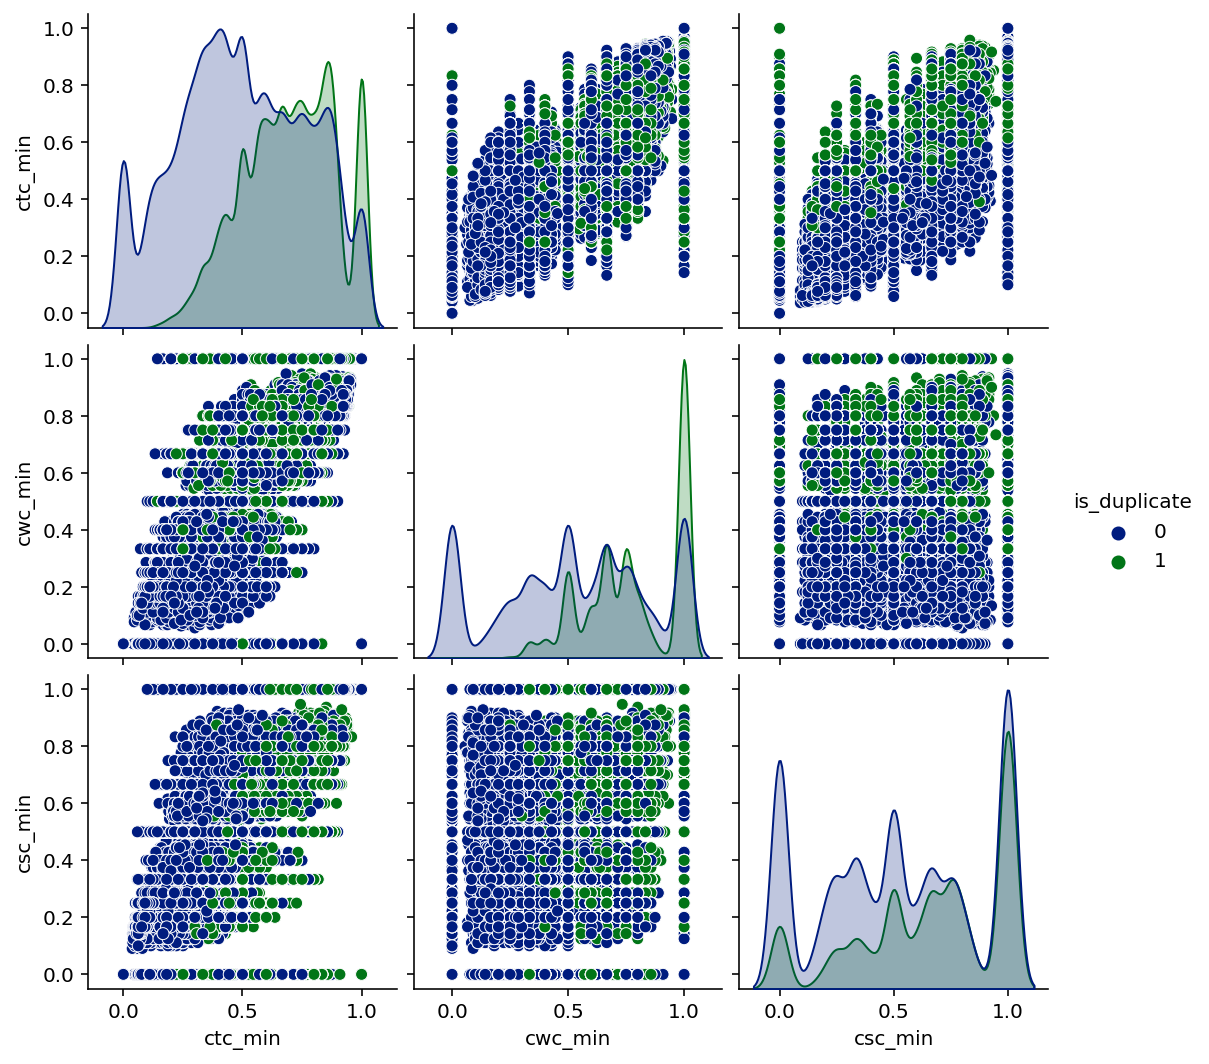

In [49]:
sns.pairplot(sample_df[['ctc_min', 'cwc_min', 'csc_min', 'is_duplicate']],hue='is_duplicate')

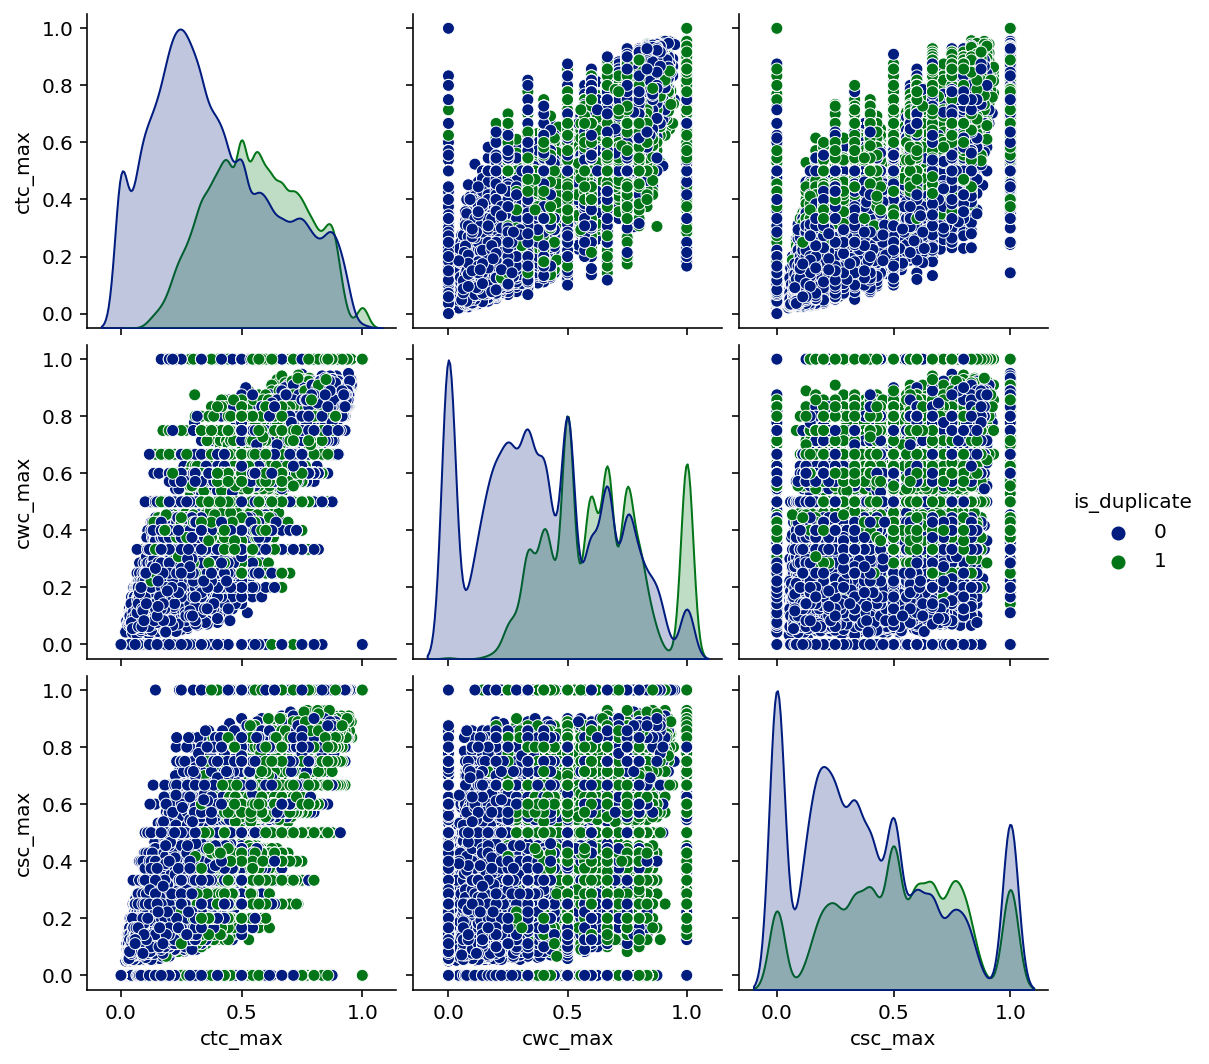

In [50]:
sns.pairplot(sample_df[['ctc_max', 'cwc_max', 'csc_max', 'is_duplicate']],hue='is_duplicate')

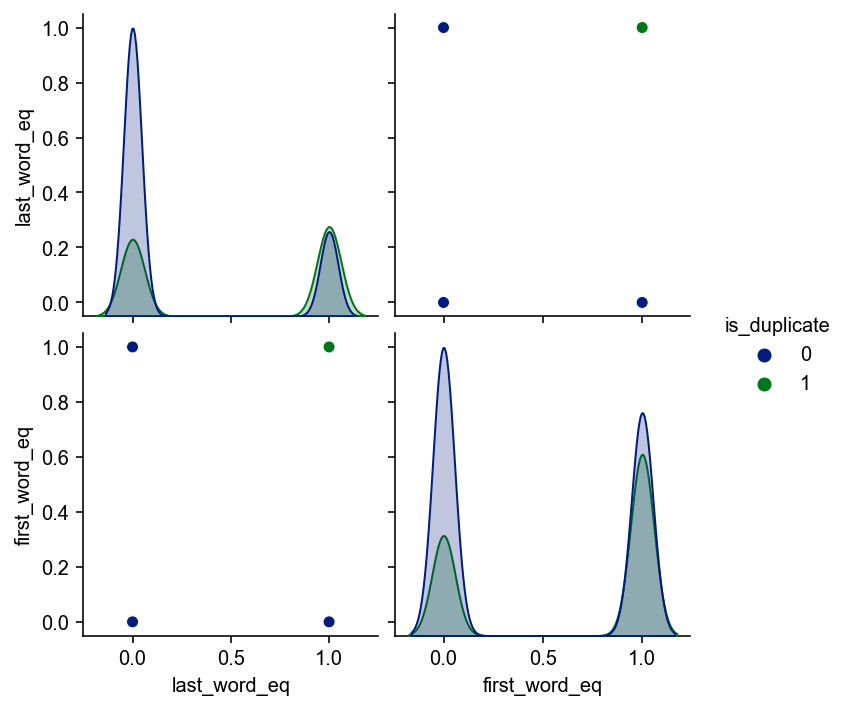

In [51]:
sns.pairplot(sample_df[['last_word_eq', 'first_word_eq', 'is_duplicate']],hue='is_duplicate')
sns.set(rc={'figure.figsize':(15,10)})


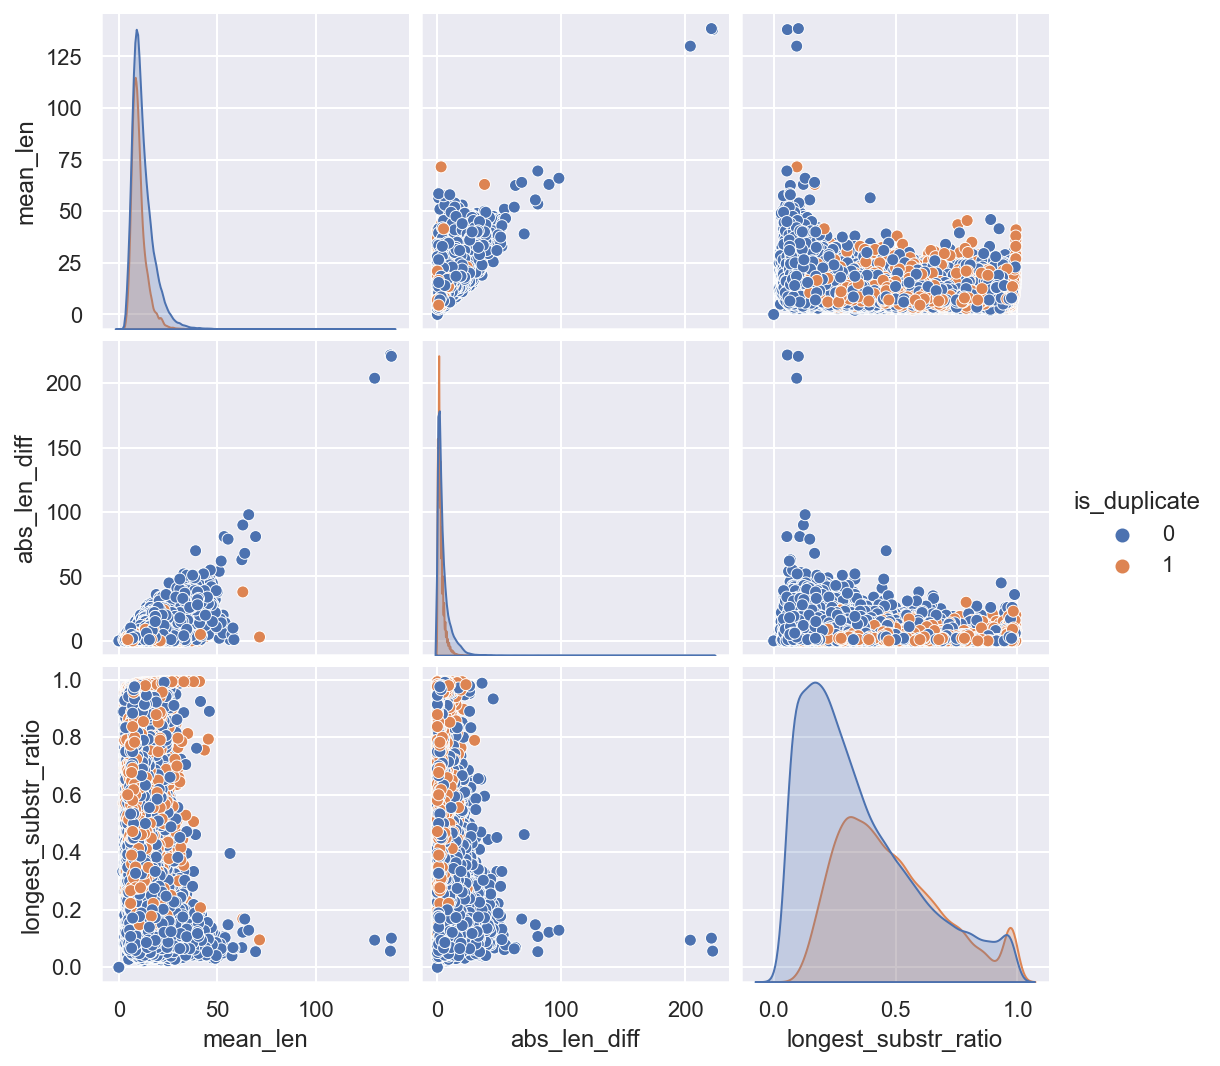

In [52]:
sns.pairplot(sample_df[['mean_len', 'abs_len_diff','longest_substr_ratio', 'is_duplicate']],hue='is_duplicate')

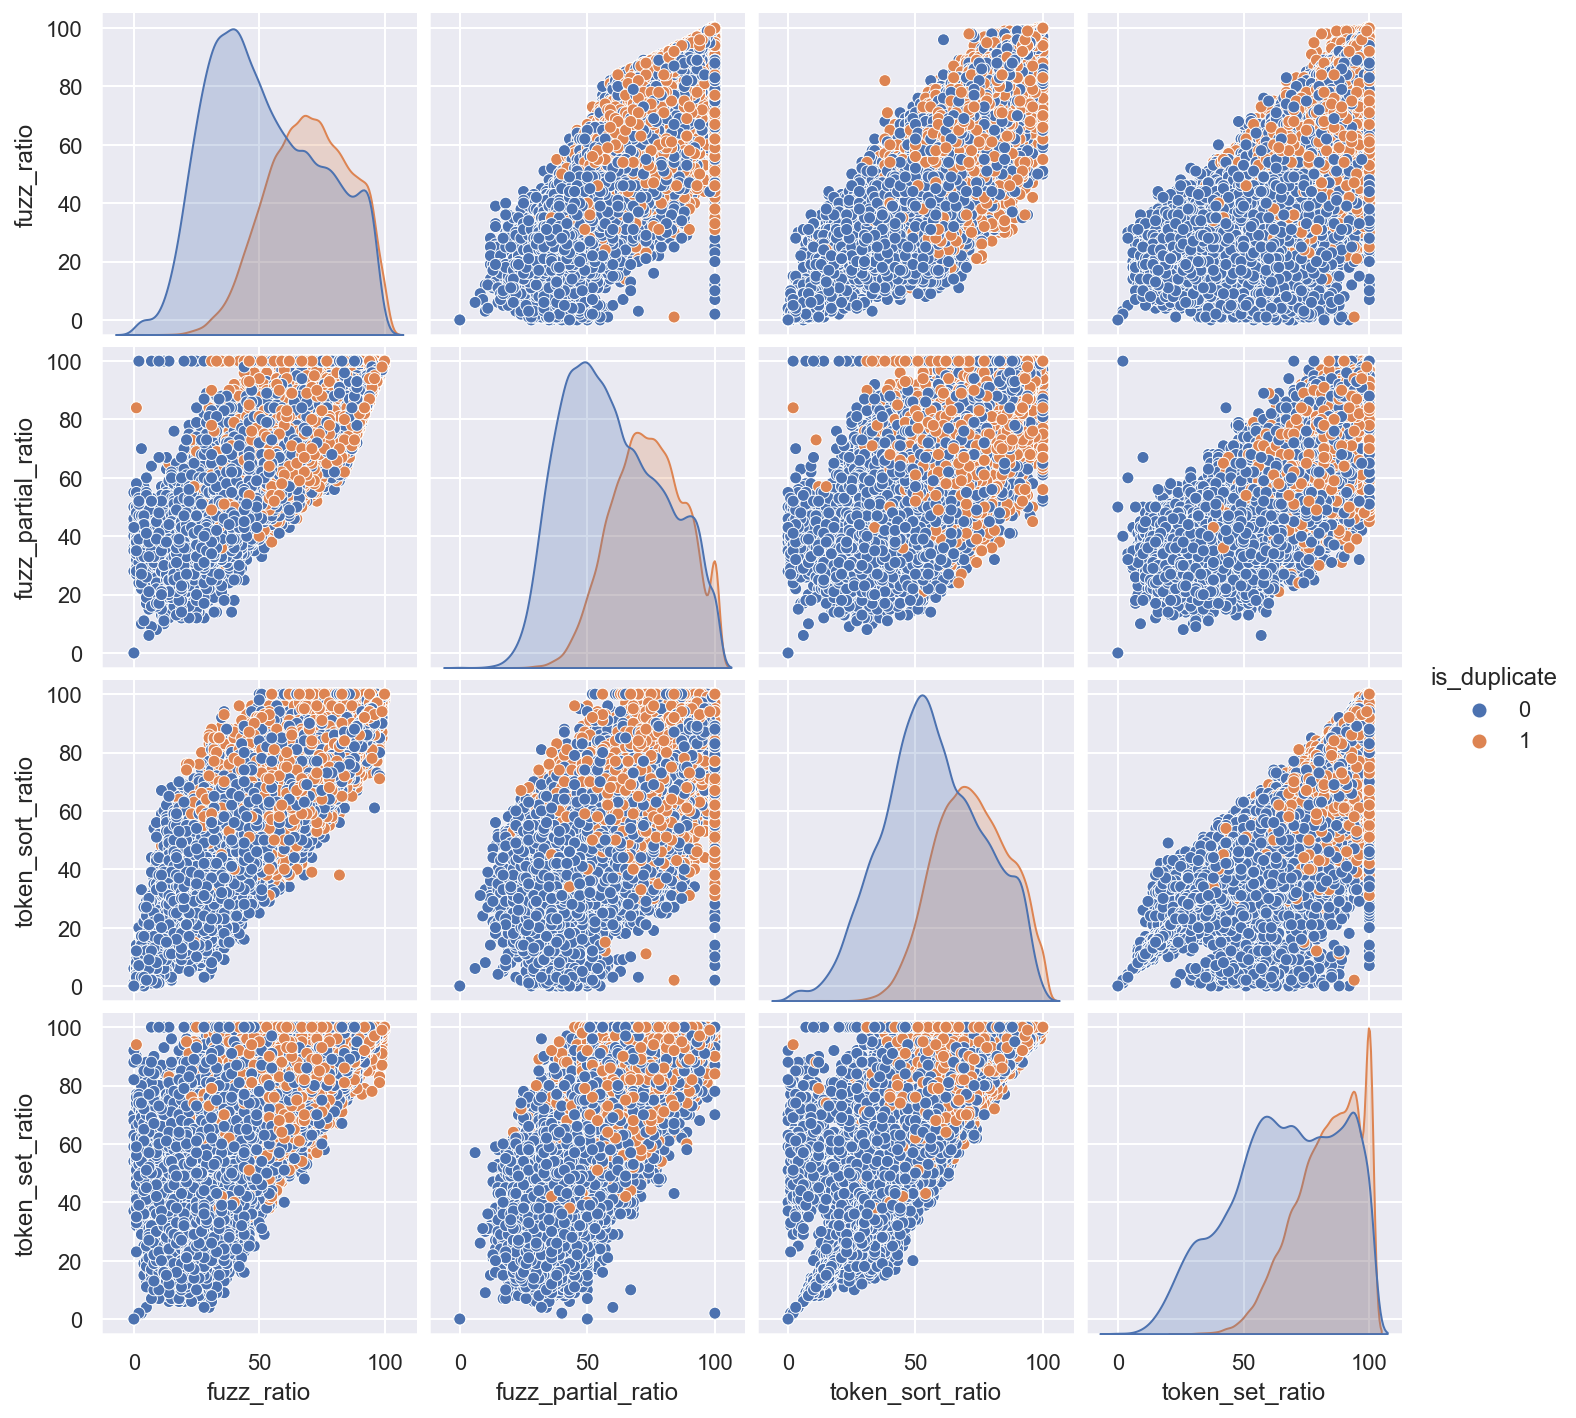

In [53]:
sns.pairplot(sample_df[['fuzz_ratio', 'fuzz_partial_ratio','token_sort_ratio','token_set_ratio', 'is_duplicate']],hue='is_duplicate')

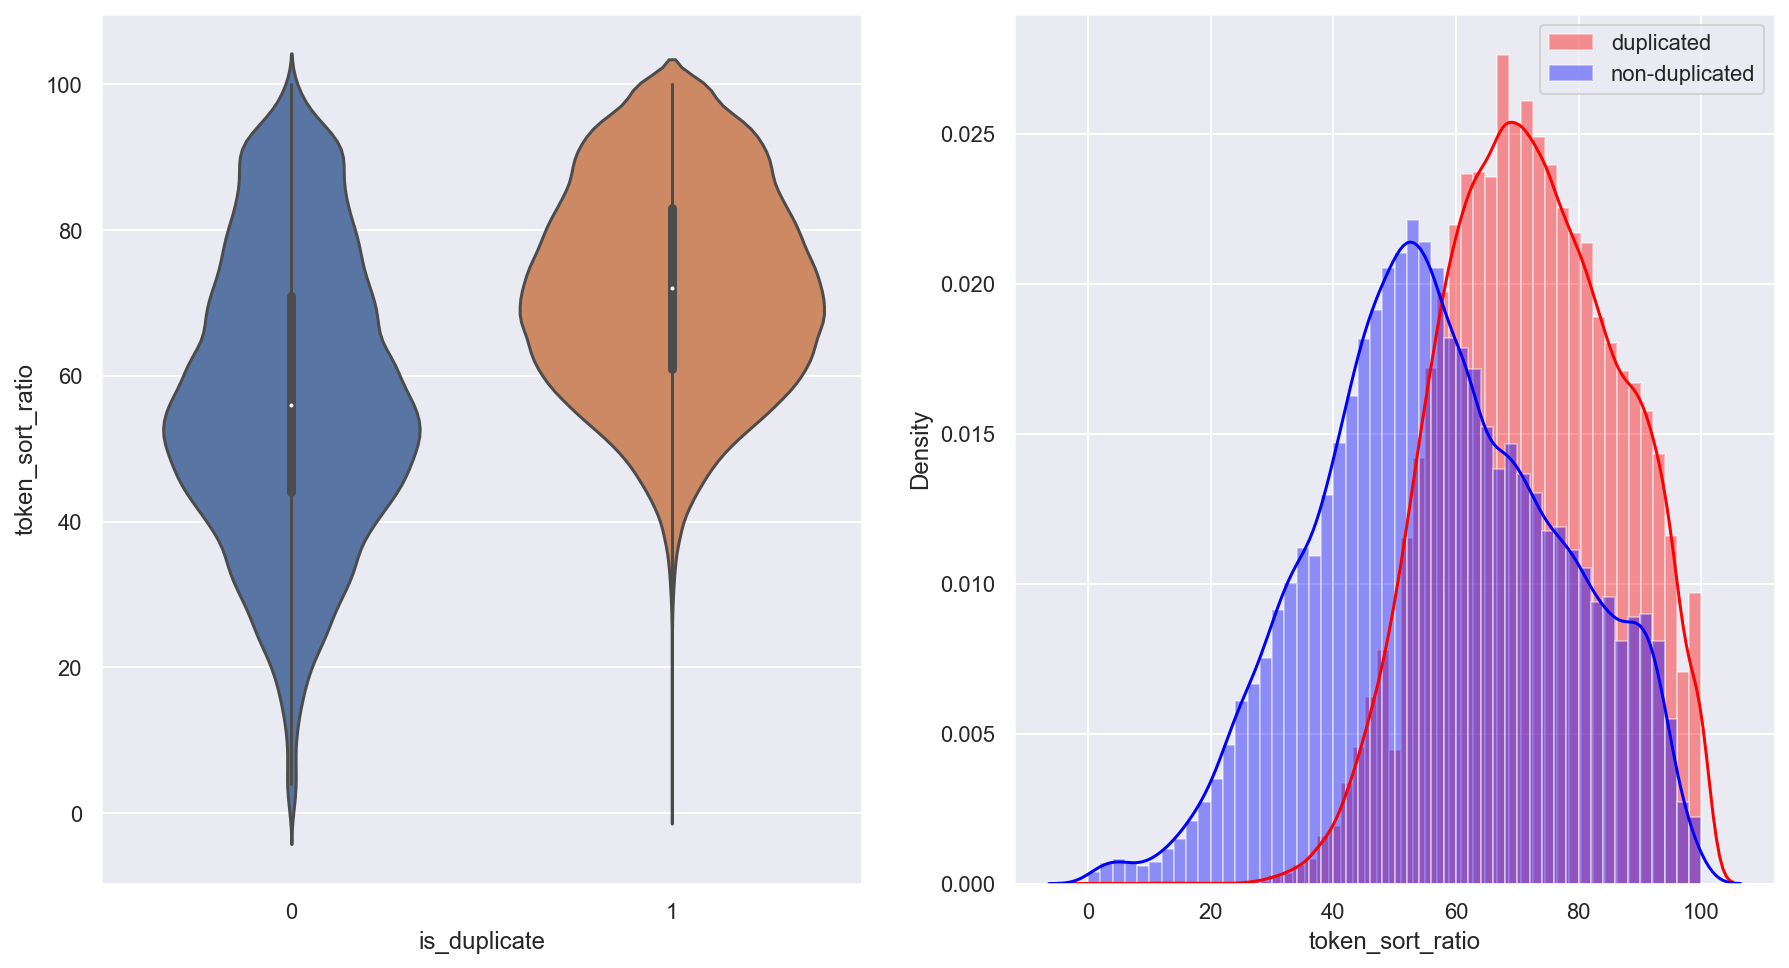

In [54]:
# Distribution of the token_sort_ratio
plt.figure(figsize=(15, 8))

plt.subplot(1,2,1)
sns.violinplot(x ='is_duplicate', y ='token_sort_ratio', data = sample_df[0:], )

plt.subplot(1,2,2)
sns.distplot(sample_df[sample_df['is_duplicate'] == 1.0]['token_sort_ratio'][0:], label = "duplicated", color = 'red')
sns.distplot(sample_df[sample_df['is_duplicate'] == 0.0]['token_sort_ratio'][0:], label = "non-duplicated" , color = 'blue' )
plt.legend()
plt.show()

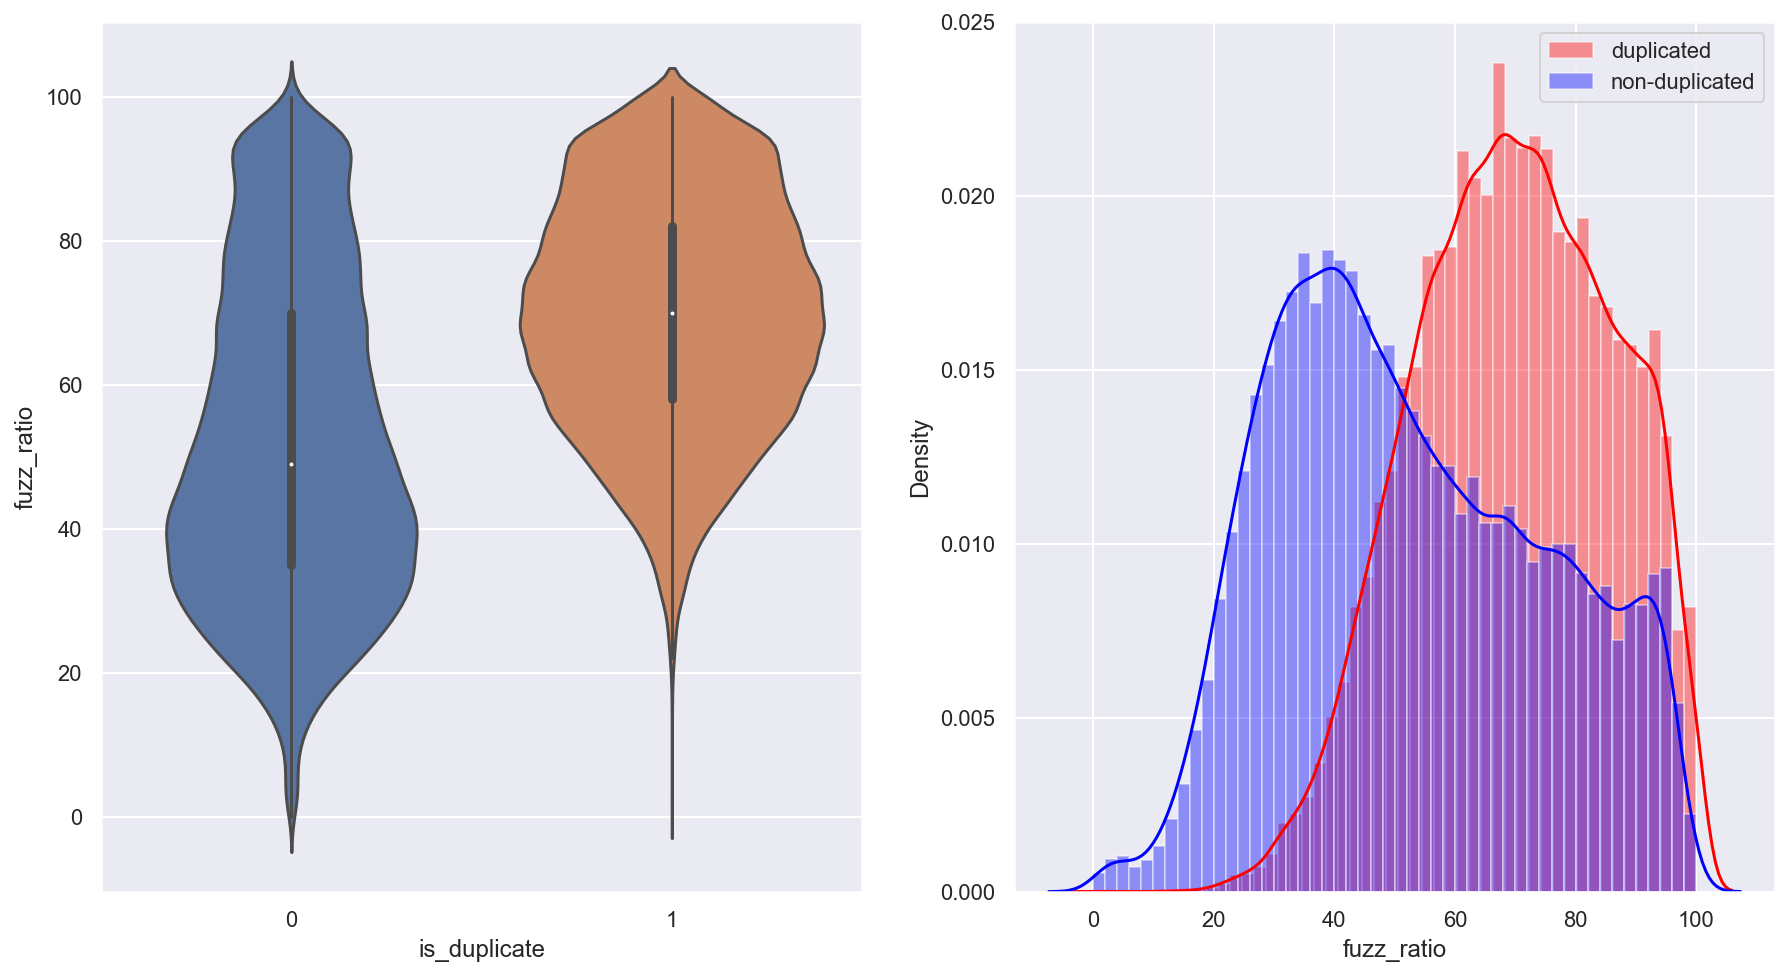

In [55]:
#Distribution of the fuzz_ratio
plt.figure(figsize=(15, 8))

plt.subplot(1,2,1)
sns.violinplot(x ='is_duplicate', y ='fuzz_ratio', data = sample_df[0:], )

plt.subplot(1,2,2)
sns.distplot(sample_df[sample_df['is_duplicate'] == 1.0]['fuzz_ratio'][0:], label = "duplicated", color = 'red')
sns.distplot(sample_df[sample_df['is_duplicate'] == 0.0]['fuzz_ratio'][0:], label = "non-duplicated" , color = 'blue' )
plt.legend()
plt.show()

## Visualization

In [56]:
# Using TSNE for Dimentionality reduction for 15 Features(Generated after cleaning the data) to 2 dimension
from sklearn.preprocessing import MinMaxScaler

X = MinMaxScaler().fit_transform(sample_df[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = sample_df['is_duplicate'].values

In [57]:
from sklearn.manifold import TSNE

tsne2d = TSNE(
    n_components=2,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 100000 samples in 0.190s...
[t-SNE] Computed neighbors for 100000 samples in 27.022s...
[t-SNE] Computed conditional probabilities for sample 1000 / 100000
[t-SNE] Computed conditional probabilities for sample 2000 / 100000
[t-SNE] Computed conditional probabilities for sample 3000 / 100000
[t-SNE] Computed conditional probabilities for sample 4000 / 100000
[t-SNE] Computed conditional probabilities for sample 5000 / 100000
[t-SNE] Computed conditional probabilities for sample 6000 / 100000
[t-SNE] Computed conditional probabilities for sample 7000 / 100000
[t-SNE] Computed conditional probabilities for sample 8000 / 100000
[t-SNE] Computed conditional probabilities for sample 9000 / 100000
[t-SNE] Computed conditional probabilities for sample 10000 / 100000
[t-SNE] Computed conditional probabilities for sample 11000 / 100000
[t-SNE] Computed conditional probabilities for sample 12000 / 100000
[t-SNE] Computed conditional probab

[t-SNE] Iteration 600: error = 3.6223707, gradient norm = 0.0002038 (50 iterations in 17.399s)
[t-SNE] Iteration 650: error = 3.4866903, gradient norm = 0.0001759 (50 iterations in 16.683s)
[t-SNE] Iteration 700: error = 3.3700407, gradient norm = 0.0001544 (50 iterations in 17.477s)
[t-SNE] Iteration 750: error = 3.2684395, gradient norm = 0.0001371 (50 iterations in 19.130s)
[t-SNE] Iteration 800: error = 3.1786966, gradient norm = 0.0001229 (50 iterations in 19.179s)
[t-SNE] Iteration 850: error = 3.0985906, gradient norm = 0.0001112 (50 iterations in 18.550s)
[t-SNE] Iteration 900: error = 3.0266838, gradient norm = 0.0001015 (50 iterations in 18.540s)
[t-SNE] Iteration 950: error = 2.9617312, gradient norm = 0.0000931 (50 iterations in 19.173s)
[t-SNE] Iteration 1000: error = 2.9026761, gradient norm = 0.0000859 (50 iterations in 19.385s)
[t-SNE] KL divergence after 1000 iterations: 2.902676


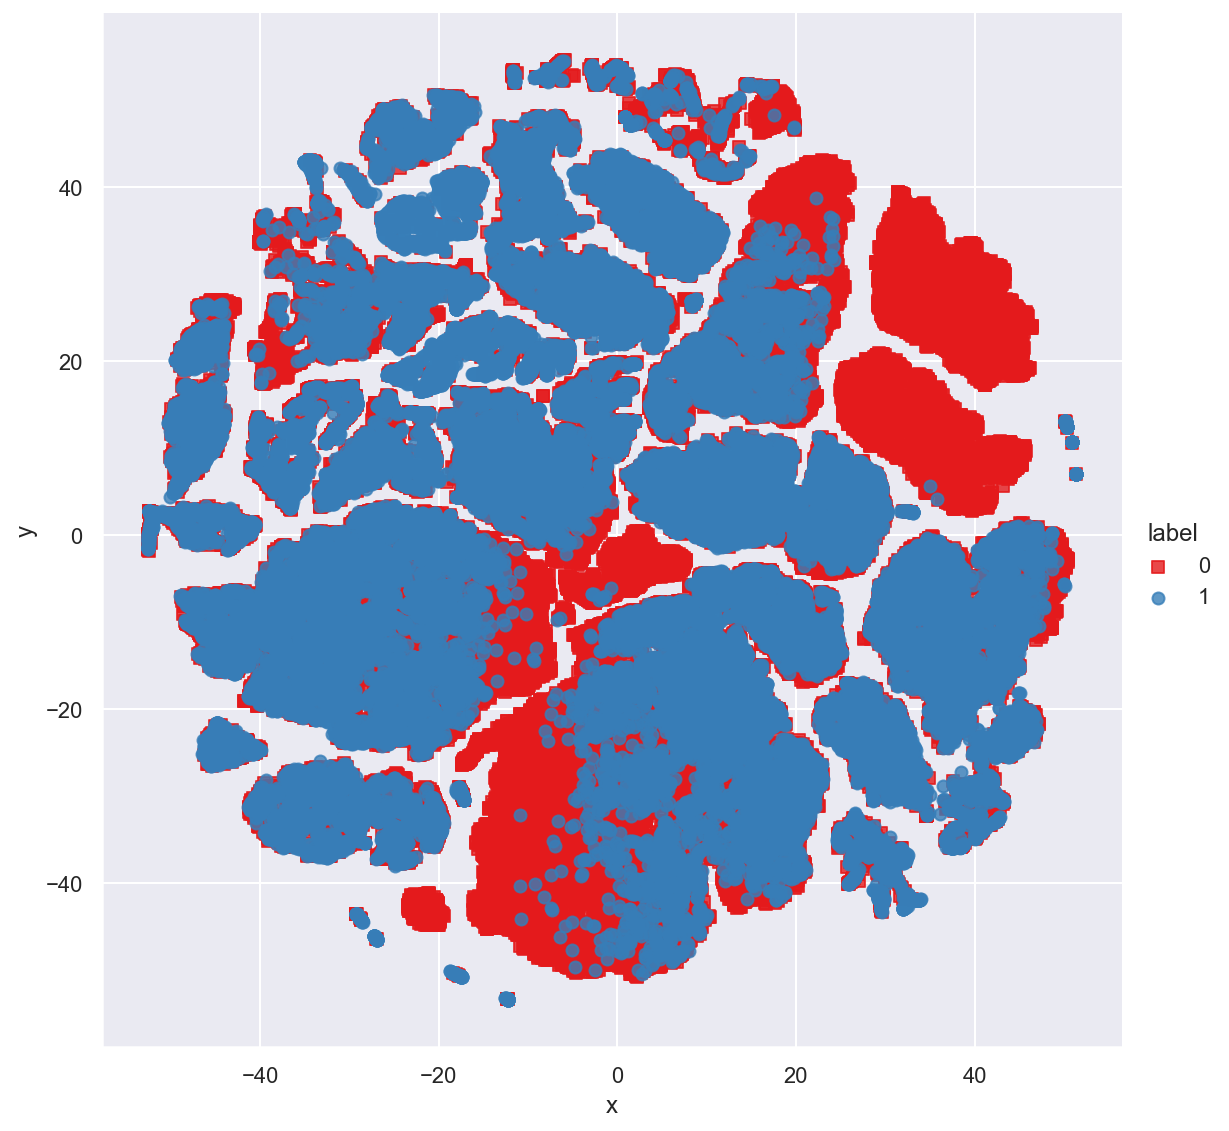

In [58]:
x_df = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=x_df, x='x', y='y', hue='label', fit_reg=False, size=8,palette="Set1",markers=['s','o'])

In [59]:
ques_df = sample_df[['question1','question2']]
ques_df.head()


question1  \
8067                    how do i play pokémon go in korea   
368101   what are some of the best side dish for crab ...   
70497    which is more advisable and better material f...   
226567         how do i improve logical programming skill   
73186               how close we are to see 3rd world war   

                                                question2  
8067                    how do i play pokémon go in china  
368101   what are some good side dish for buffalo chicken  
70497        what is the best server setup for buddypress  
226567   how can i improve my logical skill for progra...  
73186                        how close is a world war iii

In [60]:
sample_df.shape

(100000, 33)

In [61]:
sample_df['question1'] = sample_df['question1'].apply(lambda x: str(x))
sample_df['question2'] = sample_df['question2'].apply(lambda x: str(x))
print(sample_df.shape)
sample_df.head(2)

(100000, 33)


id   qid1    qid2  \
8067      8067  15738   15739   
368101  368101  12736  104117   

                                                question1  \
8067                    how do i play pokémon go in korea   
368101   what are some of the best side dish for crab ...   

                                                question2  is_duplicate  \
8067                    how do i play pokémon go in china             0   
368101   what are some good side dish for buffalo chicken             0   

        q1len  q2len  q1_n_words  q2_n_words  ...   ctc_max  last_word_eq  \
8067       34     34           8           8  ...  0.874989           0.0   
368101     53     51          11           9  ...  0.545450           0.0   

        first_word_eq  abs_len_diff  mean_len  longest_substr_ratio  \
8067              1.0           0.0       8.0              0.828571   
368101            1.0           2.0      10.0              0.300000   

        fuzz_ratio  fuzz_partial_ratio  token_sort_ratio  token_set_ratio  
8067            88                  88                81               90  
368101          72                  71                72               72  

[2 rows x 33 columns]

In [62]:
y = sample_df['is_duplicate']
X = sample_df[sample_df.drop(columns=['id', 'qid1', 'qid2','is_duplicate']).columns.tolist()]
print(X.shape)
print(y.shape)

(100000, 29)
(100000,)


## Train test split

In [63]:
from sklearn.model_selection import train_test_split

In [64]:
X_train,X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3,random_state=42)
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (70000, 29)
Number of data points in test data : (30000, 29)


## Handling text data

### TF_ IDF

In [65]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [66]:
tfidf_vectorizer1 = TfidfVectorizer(analyzer='word',lowercase=False,max_features= 20000)
trainqs1_tfidf = tfidf_vectorizer1.fit_transform(X_train['question1'])
testqs1_tfidf  = tfidf_vectorizer1.transform(X_test['question1'])
print(trainqs1_tfidf.shape)
print(testqs1_tfidf.shape)

(70000, 20000)
(30000, 20000)


In [67]:
tfidf_vectorizer2 = TfidfVectorizer(analyzer='word',lowercase=False,max_features= 20000)
train_qs2_tfidf = tfidf_vectorizer2.fit_transform(X_train['question2'])
test_qs2_tfidf  = tfidf_vectorizer2.transform(X_test['question2'])
print(train_qs2_tfidf.shape)
print(test_qs2_tfidf.shape)

(70000, 20000)
(30000, 20000)


In [68]:
from scipy.sparse import hstack
tfidf_train_vec = hstack((trainqs1_tfidf,train_qs2_tfidf))
tfidf_test_vec = hstack((testqs1_tfidf,test_qs2_tfidf)) 
print("Train data shape",tfidf_train_vec.shape)
print("Test data shape ",tfidf_test_vec.shape)

Train data shape (70000, 40000)
Test data shape  (30000, 40000)


In [69]:
# selecting other features
train_df = X_train.drop(columns=['question1', 'question2'])
test_df = X_test.drop(columns=['question1', 'question2'])

In [70]:
#we need to convert our data with features into sparse matrix so that we can combine our feature matrix and tfidf vectors 
import scipy
train_sparse = scipy.sparse.csr_matrix(train_df)
test_sparse = scipy.sparse.csr_matrix(test_df)

In [71]:
# Now combining our tfidf and features into one 
tfidf_X_tr = hstack((train_sparse,tfidf_train_vec))
tfidf_X_test = hstack((test_sparse,tfidf_test_vec))
print("train data shape",tfidf_X_tr.shape)
print("Test data shape ",tfidf_X_test.shape)

train data shape (70000, 40027)
Test data shape  (30000, 40027)


In [72]:
import os , pickle
#saving tfidf vectors
pickle.dump(tfidf_X_tr, open("tfidf_X_tr","wb"))
pickle.dump(tfidf_X_test, open("tfidf_X_test","wb"))

In [73]:
y_train.to_csv('train_y.csv',index=False)
y_test.to_csv('test_y.csv',index=False)

# Machine Learning

In [74]:
#tfidf-w2v
X_train = tfidf_X_tr
X_test =tfidf_X_test

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(70000, 40027)
(30000, 40027)
(70000,)
(30000,)


# Random Forest

In [75]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
accuracy_score(y_test,y_pred)

0.8106666666666666

### Random Forest with Hyperparameter Tuning

In [76]:
from sklearn.model_selection import GridSearchCV

In [77]:
# param_grid = {'bootstrap': [True],
#               'max_features': ['sqrt','log2'],
#               'n_estimators': [200, 400],
#               'criterion':['gini', 'entropy', 'log_loss'],
#               'max_samples':[5000, 10000, 20000],
#               'verbose':[1],
#              }

In [78]:
# clf = GridSearchCV(rf, param_grid, cv =5, scoring='accuracy')
# clf.fit(X_train, y_train)

In [79]:
#print(clf.best_params_)

In [80]:
rf_final = RandomForestClassifier(bootstrap=True, criterion= 'entropy', max_features='sqrt', max_samples= 20000, n_estimators= 200, verbose= 1)
rf_final.fit(X_train,y_train)
y_pred_final = rf.predict(X_test)
accuracy_score(y_test,y_pred)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  3.5min finished


0.8106666666666666

In [81]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

print(classification_report(y_test, y_pred_final))
print(confusion_matrix(y_test, y_pred_final))

              precision    recall  f1-score   support

           0       0.84      0.87      0.85     18864
           1       0.76      0.71      0.74     11136

    accuracy                           0.81     30000
   macro avg       0.80      0.79      0.79     30000
weighted avg       0.81      0.81      0.81     30000

[[16369  2495]
 [ 3185  7951]]


# Logistic Regression

In [82]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
logModel =  LogisticRegression()


In [83]:
logModel.fit(X_train, y_train)
y_pred_log = logModel.predict(X_test)
accuracy_score(y_test,y_pred_log)

0.6979666666666666

In [84]:
lm_tuned= LogisticRegression(C=1.0, max_iter=100, multi_class= 'auto', penalty= 'l2', solver='saga', verbose=1)
lm_tuned.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 5 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s finished


LogisticRegression(solver='saga', verbose=1)

In [85]:
y_pred_lm = lm_tuned.predict(X_test)
accuracy_score(y_test,y_pred_lm)

0.6674333333333333

# SVM

In [86]:
from sklearn.svm import SVC
model_Svc = SVC()

In [87]:
model_Svc.fit(X_train, y_train)
y_pred_Svc = model_Svc.predict(X_test)
accuracy_score(y_test,y_pred_Svc)

0.7149333333333333

In [88]:
model_Svc_tuned=SVC(C=100, gamma= 'scale', kernel= 'poly', max_iter= 1000, verbose= 1)
model_Svc_tuned.fit(X_train, y_train)
y_pred_Svc_tuned = model_Svc_tuned.predict(X_test)
accuracy_score(y_test,y_pred_Svc_tuned)


[LibSVM]

0.6728666666666666

# Preparing function for input 

### Basic Feature Extraction¶

In [89]:
lemmatizer = WordNetLemmatizer()
def lemma(q):
    x=""
   
    ques = nltk.word_tokenize(q)
   
    for word in q:
        x=x +(lemmatizer.lemmatize(word, pos='n'))
    
        
    return x



In [90]:
# q1 = 'Where is the capital of India?'
# q2 = 'What is the current capital of Pakistan?'
# q3 = 'Which city serves as the capital of India?'
# q4 = 'What is the business capital of India?'

In [91]:
# lemma(q1)

In [92]:
def test_common_words(q1,q2):
    w1 = set(map(lambda word: word.lower().strip(), q1.split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), q2.split(" ")))    
    return len(w1 & w2)

In [93]:
def test_total_words(q1,q2):
    w1 = set(map(lambda word: word.lower().strip(), q1.split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), q2.split(" ")))    
    return (len(w1) + len(w2))

In [94]:
def test_word_difference_1(q1, q2):
    w1 = set(map(lambda word: word.lower().strip(), q1.split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), q2.split(" ")))    
    return 1.0 * len(w1.difference(w2))



In [95]:
def test_word_difference_2(q1, q2):
    w1 = set(map(lambda word: word.lower().strip(), q2.split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), q1.split(" ")))    
    return 1.0 * len(w2.difference(w1))

In [96]:
def test_fetch_token_features(q1,q2):
    
    SAFE_DIV = 0.0001 

    STOP_WORDS = stopwords.words("english")
    
    token_features = [0.0]*8
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features

    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    return token_features

In [97]:
def test_fetch_length_features(q1,q2):
    
    length_features = [0.0]*3
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return length_features
    
    # Absolute length features
    length_features[0] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    length_features[1] = (len(q1_tokens) + len(q2_tokens))/2
    
    strs = list(distance.lcsubstrings(q1, q2))
    length_features[2] = len(strs[0]) / (min(len(q1), len(q2)) + 1)
    
    return length_features

In [98]:
def test_fetch_fuzzy_features(q1,q2):
    
    fuzzy_features = [0.0]*4
    
    # fuzz_ratio
    fuzzy_features[0] = fuzz.QRatio(q1, q2)

    # fuzz_partial_ratio
    fuzzy_features[1] = fuzz.partial_ratio(q1, q2)

    # token_sort_ratio
    fuzzy_features[2] = fuzz.token_sort_ratio(q1, q2)

    # token_set_ratio
    fuzzy_features[3] = fuzz.token_set_ratio(q1, q2)

    return fuzzy_features

In [99]:
def query_point_creator(q1,q2):
    
    input_query = []
    
    # preprocess
    q1 = preprocess(q1)
    q2 = preprocess(q2)
    
     #lemmatizer
    q1=lemma(q1)
    q2=lemma(q2)
    
    # fetch basic features
    input_query.append(len(q1))
    input_query.append(len(q2))
    
    input_query.append(len(q1.split(" ")))
    input_query.append(len(q2.split(" ")))
    
    input_query.append(test_common_words(q1,q2))
    input_query.append(test_total_words(q1,q2))
    input_query.append(round(test_common_words(q1,q2)/test_total_words(q1,q2),2))
    input_query.append(test_word_difference_1(q1,q2))
    input_query.append(test_word_difference_2(q1,q2))
    
    #absolute distance between length of q1 n q2 str
    input_query.append(abs(len(q1)-len(q2)))
    
    #No of questions in q1 and q2
    input_query.append(q1.count('?'))
    input_query.append(q2.count('?'))
    
    # fetch token features
    token_features = test_fetch_token_features(q1,q2)
    input_query.extend(token_features)
    
    # fetch length based features
    length_features = test_fetch_length_features(q1,q2)
    input_query.extend(length_features)
    
    # fetch fuzzy features
    fuzzy_features = test_fetch_fuzzy_features(q1,q2)
    input_query.extend(fuzzy_features)
    
    #Tf-idf
   
    q1_tfidf= tfidf_vectorizer1.transform([q1]).toarray()
    q2_tfidf=tfidf_vectorizer2.transform([q2]).toarray()
   

    
    return np.hstack((np.array(input_query).reshape(1,27),q1_tfidf,q2_tfidf))

In [100]:
q1 = 'Mansi is really very beautiful'
q2 = 'Mansi is extremely beautiful'
q3 = 'Which city serves as the capital of India?'
q4 = 'What is the business capital of India?'

In [101]:
a=query_point_creator(q1, q2)

In [102]:
a.shape

(1, 40027)

In [103]:
rf_final.predict(query_point_creator(q1,q2))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished


array([1], dtype=int64)

In [104]:
rf_final.predict(query_point_creator(q3,q4))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished


array([0], dtype=int64)

In [107]:
pickle.dump(rf_final, open('rf_final.pkl','wb'))

In [108]:
pickle.dump(tfidf_vectorizer1, open('tfidf_vectorizer1.pkl','wb'))
pickle.dump(tfidf_vectorizer2, open('tfidf_vectorizer2.pkl','wb'))